In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_cc")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    for i in range(1, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)
    return np.mean(periods)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_cc


In [8]:
def plotspectrum(data, fmax=1., filename=None):

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)]

        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        plt.plot(fr, ps_plot)

    plt.xlim(-0.01,fmax)
    plt.ylim(0,1.1*np.amax(ps_plot))
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

def plot_EI_trajectory(m, tstart= 100000, filename=None):

    plt.plot(m.exc[0,tstart:], m.inh[0,tstart:], color="gray", linewidth=0.1)
    plt.plot(m.exc[1,tstart:], m.inh[1,tstart:], color="gray", linewidth=0.2, linestyle=":")

    plt.xlabel("E")
    plt.ylabel("I")
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))


    plt.show()

    return

def recurrence_plot(data, threshold=0.01):
    N = len(data)
    distance_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance_matrix[i, j] = np.abs(data[i] - data[j])

    # Create the recurrence plot
    recurrence_plot = np.where(distance_matrix <= threshold, 1, 0)

    return recurrence_plot

def show_recplot(data, threshold=0.1):
    plt.figure(figsize=(8, 8))
    recurrence=recurrence_plot(data, threshold)
    plt.imshow(recurrence, cmap='binary', origin='lower')
    plt.title('Recurrence Plot')
    plt.xlabel('Time')
    plt.ylabel('Time')
    plt.colorbar(label='Recurrence')
    plt.show()

    return


NameError: name 'data' is not defined

--------------------------------------------------------------  [1.0, 0.1, 1.0]


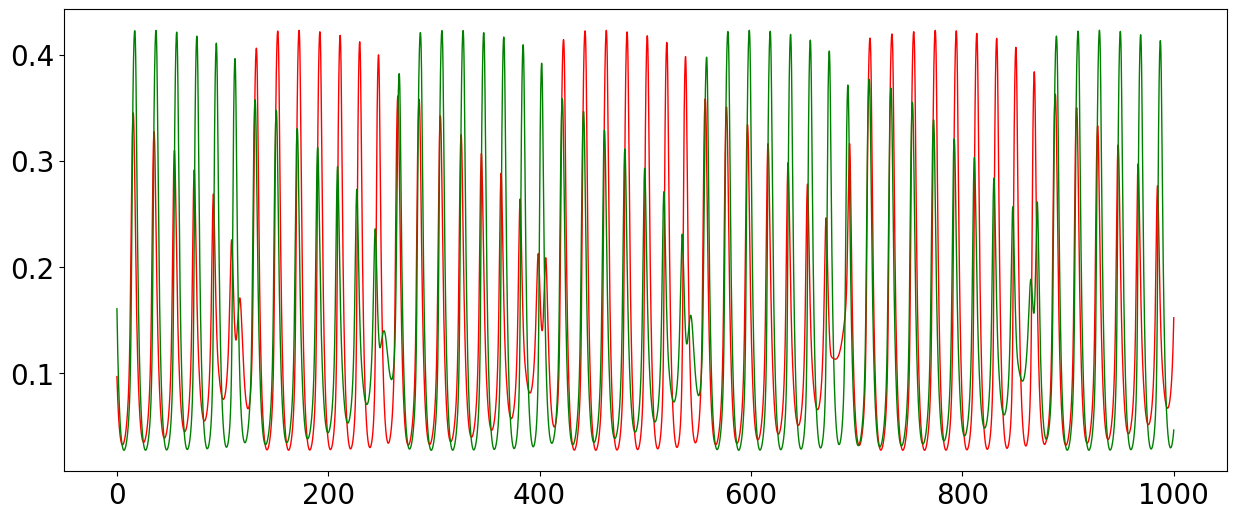

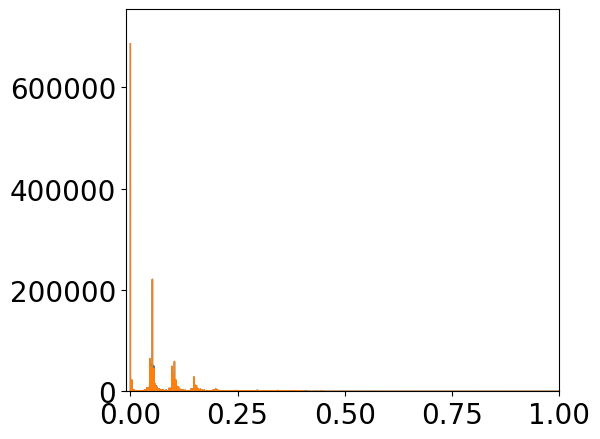

freq of max =  [0.05140002]
period of max =  [19.45524514]
time ind min =  1950401
time ind min =  112572


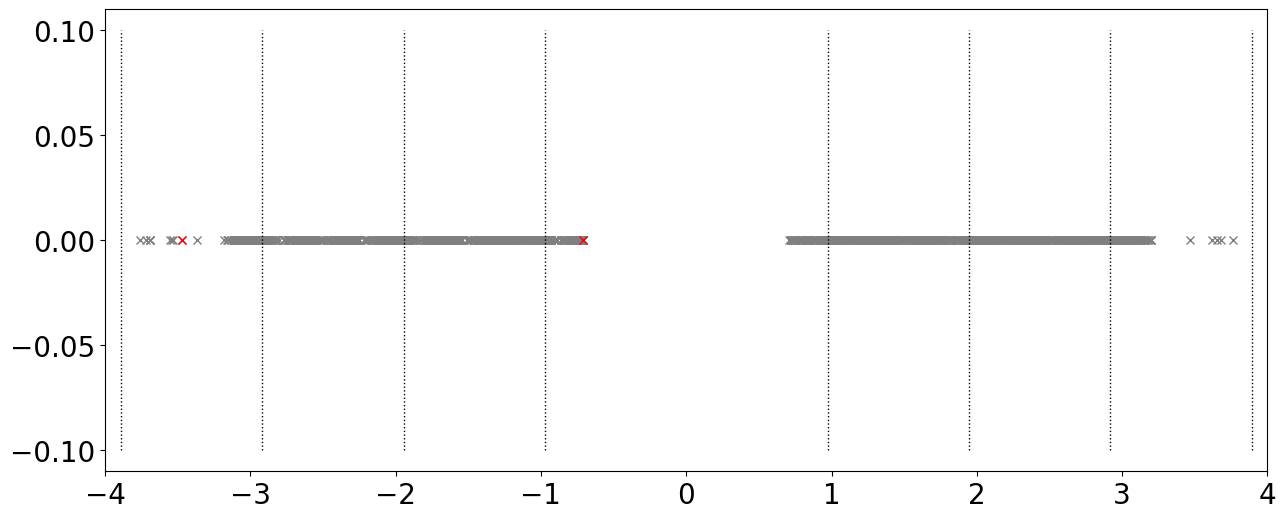

In [46]:
points = [

#[0.9, 0.0, 1.0],
#[0.9, 0.0, 1.5],
#[1.0, 0.0, 1.0],
[1.0, 0.1, 1.0],# ==> nice one
#[1.5, 0.3, 0.5],
##### [1.7, 0.8, 0.5], # => nice one
#[1.8, 0.9, 0.5],
#[1.8, 0.9, 1.0],
#[1.9, 0.3, 0.0], # => slow oscillation
]

coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

data = dict()

data["weights"] = np.ones((3,2,3))
data["control"] = [[[None for x0 in range(3)] for x1 in range(2)] for x2 in range(3)]  # 3 cost functionals, 2 initial conditions,3 weights
data["state"] = [[[None for x0 in range(3)] for x1 in range(2)] for x2 in range(3)]
data["init"] = [None for x1 in range(2)]
data["control_cost"] = np.zeros((3,2,3))
data["sync_cost"] = np.zeros((3,2,3))

for pi in points:

    print("-------------------------------------------------------------- ", pi)

    model = WCModel(Cmat=cmat, Dmat=pi[2]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = pi[0]
    model.params.inh_ext_baseline = pi[1]

    model.params.K_gl = coupling

    if False:
        model.params.dt = 0.1
        model.run()

        plt.figure(figsize=(15,6))
        plt.plot(model.exc[0,-int(1000/model.params.dt):], linewidth=1, color="red")
        plt.plot(model.exc[1,-int(1000/model.params.dt):], linewidth=1, color="green")
        plt.show()
        plot_EI_trajectory(model, tstart = int(10000/model.params.dt))

    model.params.dt = 0.01
    model.run()

    plt.figure(figsize=(15,6))
    durplot = 1000
    plt.plot(np.arange(0,durplot, model.params.dt), model.exc[0,-int(durplot/model.params.dt):], linewidth=1, color="red")
    plt.plot(np.arange(0,durplot, model.params.dt), model.exc[1,-int(durplot/model.params.dt):], linewidth=1, color="green")
    plt.show()
    #plot_EI_trajectory(model, tstart = int(10000/model.params.dt))

    period = plotspectrum( [model.exc[0,-int(50000/model.params.dt):], model.exc[1,-int(50000/model.params.dt):] ])

    peak_time_differences = []

    peaks0 = scipy.signal.find_peaks(model.exc[0,-int(50000/model.params.dt):], prominence=0.1)[0]
    peaks1 = scipy.signal.find_peaks(model.exc[1,-int(50000/model.params.dt):], prominence=0.1)[0]

    plt.figure(figsize=(15,6))
    for p0 in peaks0[2:-2]:
        mindiff = 1000
        for p1 in peaks1:
            if np.abs(p1 - p0) < mindiff:
                mindiff = p1 - p0

        peak_time_differences.append(mindiff*model.params.dt)

        plt.plot(mindiff*model.params.dt, 0, marker="x", color="gray")

    min_ptd = 0
    for ptd in peak_time_differences:
        if ptd < min_ptd and ptd > -3.5 and ptd < -0.5:
            min_ptd = ptd
    min_ptd_index = np.where(peak_time_differences == min_ptd)[0][0]

    plt.plot(peak_time_differences[min_ptd_index], 0, marker="x", color="red")

    time_ind_min = peaks0[2+min_ptd_index]
    print("time ind min = ", time_ind_min)

    nmaxdelay = model.getMaxDelay()
    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,time_ind_min-nmaxdelay-1:time_ind_min]
        iinit[n,:] = model.inh[n,time_ind_min-nmaxdelay-1:time_ind_min]

    data["init"][0] = [einit, iinit]

    max_ptd = -10
    for ptd in peak_time_differences:
        if ptd > max_ptd and ptd > -1.5 and ptd < 0.:
            max_ptd = ptd
    max_ptd_index = np.where(peak_time_differences == max_ptd)[0][0]

    plt.plot(peak_time_differences[max_ptd_index], 0, marker="x", color="red")

    time_ind_max = peaks0[2+max_ptd_index]
    print("time ind min = ", time_ind_max)

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,time_ind_max-nmaxdelay-1:time_ind_max]
        iinit[n,:] = model.inh[n,time_ind_max-nmaxdelay-1:time_ind_max]

    data["init"][1] = [einit, iinit]

    plt.vlines( [-0.2*period, -0.15*period, -0.1*period, -0.05*period, 0.05*period, 0.1*period, 0.15*period, 0.2*period], -0.1, 0.1, color="black", linestyle=":" )
    plt.xlim([-4., 4])
    plt.show()

    

    if False:
        model.params.dt = 0.001
        model.run()

        plt.figure(figsize=(30,6))
        plt.plot(model.exc[0,-int(3000/model.params.dt):], linewidth=1, color="red")
        plt.plot(model.exc[1,-int(3000/model.params.dt):], linewidth=1, color="green")
        plt.show()
        plot_EI_trajectory(model, tstart = int(10000/model.params.dt))

In [61]:
controlmat = np.ones((N,2))
costmat = np.zeros((N,2))
costmat[:,0] = 1

duration = 200
control_interval = [None, None]
cost_interval = [None, None]

dt = 0.01

it = 50
maxstr = 5
pr = np.arange(0,1001,20)

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [48]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [113]:
data["weights"][:,:,0] = 1e-2
data["weights"][:,:,1] = 1.
data["weights"][:,:,2] = 1e2

data["weights"][0,:,0] = 1e-2
data["weights"][0,:,1] = 1e-1
data["weights"][0,:,2] = 1.

print(data["weights"])

from numba.typed import Dict
from numba.core import types

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

[[[1.e-02 1.e-01 1.e+00]
  [1.e-02 1.e-01 1.e+00]]

 [[1.e-02 1.e+00 1.e+02]
  [1.e-02 1.e+00 1.e+02]]

 [[1.e-02 1.e+00 1.e+02]
  [1.e-02 1.e+00 1.e+02]]]


Optimal control with target oscillation period


/tmp/ipykernel_5796/3230118032.py:27: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[1].set_ylim(y1lim)


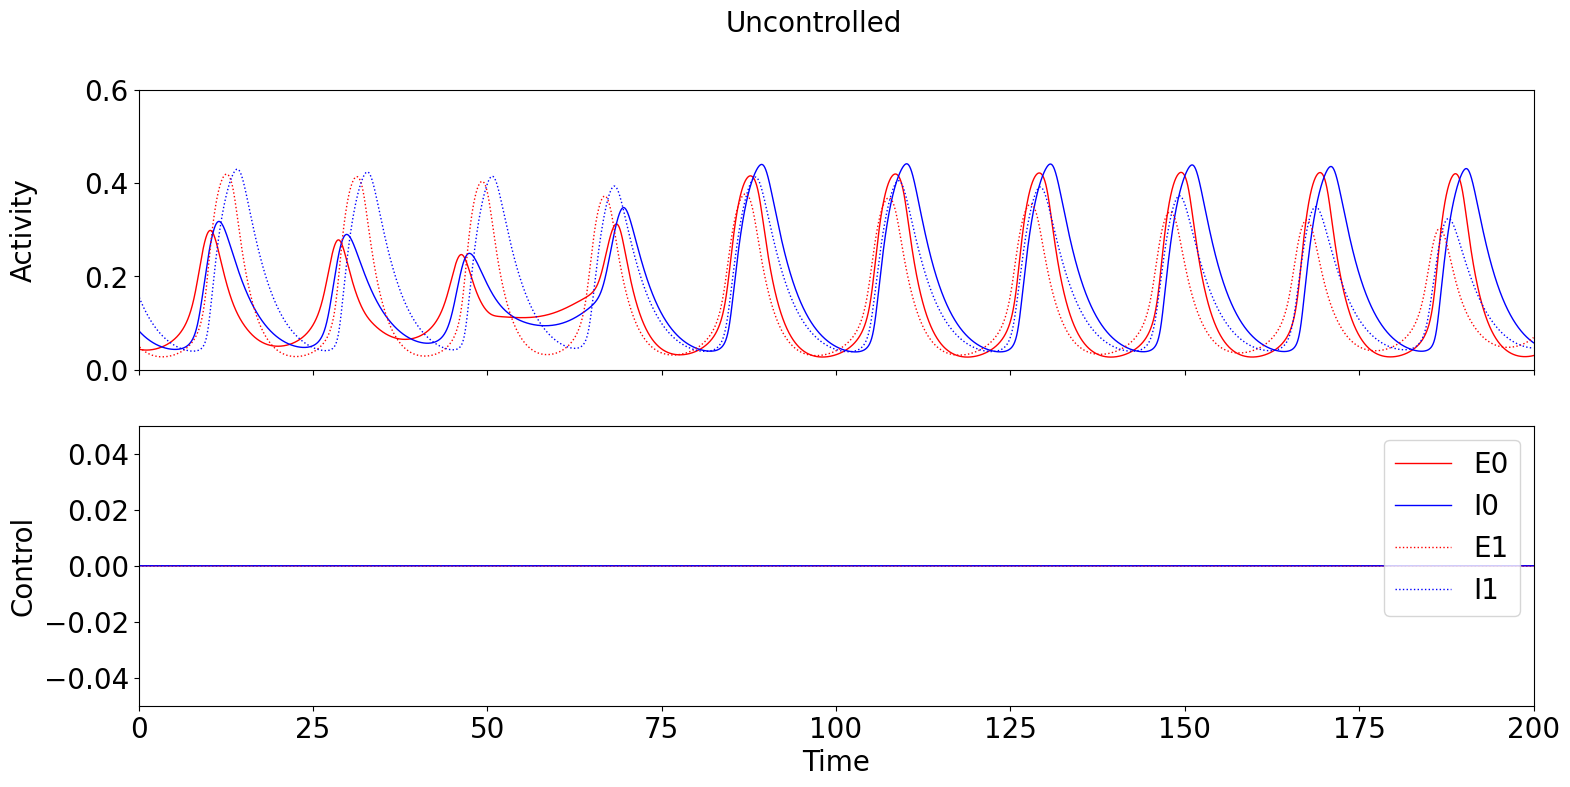

In [109]:
#### initial condition 0

it = 10

init_ind = 1

model = WCModel(Cmat=cmat, Dmat=points[0][2]*20.*cmat)

model.params['duration'] = duration
model.params.dt = dt
model.params.exc_ext_baseline = points[0][0]
model.params.inh_ext_baseline = points[0][1]
model.params.K_gl = coupling

zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))
model.params["exc_ext"] = zero_control[:,0,:]
model.params["inh_ext"] = zero_control[:,1,:]

model.params["exc_init"] = data["init"][init_ind][0]
model.params["inh_init"] = data["init"][init_ind][1]

model.run()

model_controlled = oc_wc.OcWc(model, period, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                            cost_matrix=costmat, control_matrix=controlmat)

plot_c = input.copy()
plot_s = np.concatenate( (mod.exc[:,np.newaxis,:], mod.inh[:,np.newaxis,:]), axis=1 )

filename = "syncbeat_uncontrolled_1.png"
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=os.path.join(dir,filename), title="Uncontrolled")


---------------------------------------  F
---------------------------------------  CC
w2 =  0.01
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -49.992265771522334
Cost in iteration 20: -49.992267944816874
Cost in iteration 40: -49.99227858997221
Cost in iteration 60: -49.992291120125024
Cost in iteration 80: -49.99230357522211
Cost in iteration 100: -49.99230993784818
Cost in iteration 120: -49.99231767192396
Cost in iteration 140: -49.99232575627751
Cost in iteration 160: -49.9923319676837
Cost in iteration 180: -49.992341947768196
Cost in iteration 200: -49.992350355815745
Final cost : -49.992350355815745
Compute control for a deterministic system
Cost in iteration 0: -49.992350355815745
Cost in iteration 20: -49.99235822853885
Cost in iteration 40: -49.99236528634097
Cost in iteration 60: -49.99237350569374
Cost in iteration 80: -49.992383970535045
Cost in iteration 100: -49.99239186040284
Cost in iteration 120: -49.9

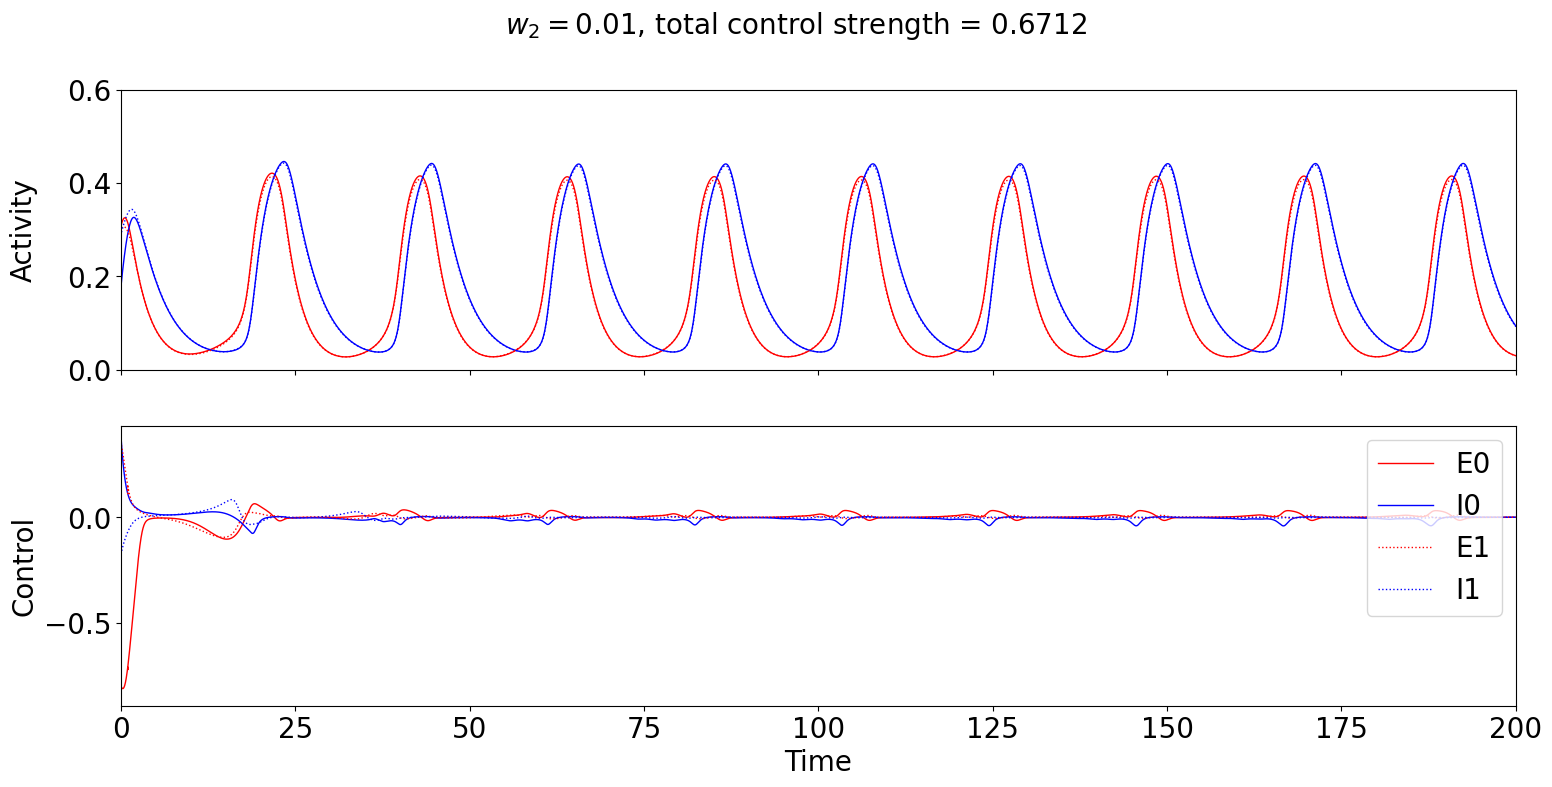

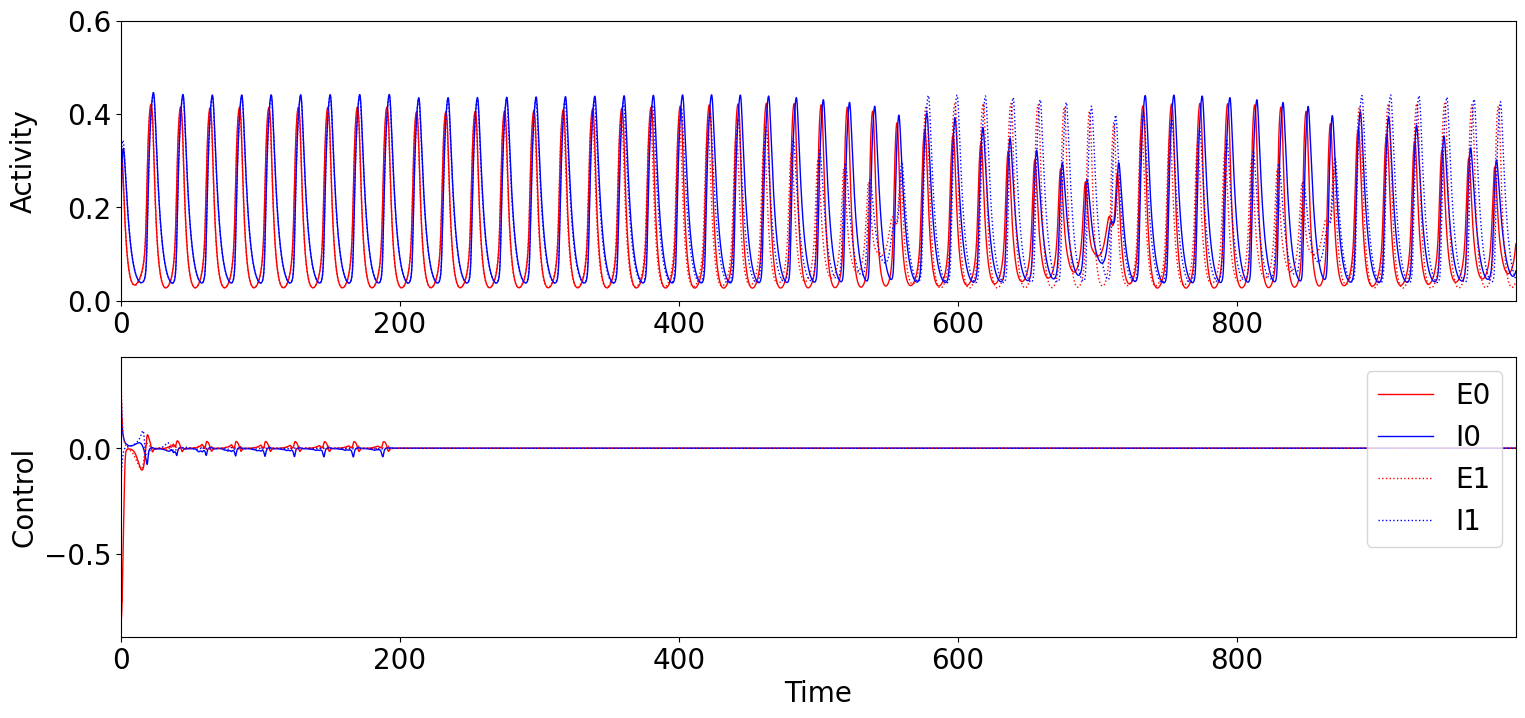

w2 =  1.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -49.6318463551814
Cost in iteration 20: -49.631861963613595
Cost in iteration 40: -49.63194685641652
Cost in iteration 60: -49.632020065542264
Cost in iteration 80: -49.63210231984772
Cost in iteration 100: -49.6321819866067
Cost in iteration 120: -49.63225323026268
Cost in iteration 140: -49.63233340533141
Cost in iteration 160: -49.632410948333295
Cost in iteration 180: -49.632480347238904
Cost in iteration 200: -49.632558497479586
Final cost : -49.632558497479586
Compute control for a deterministic system
Cost in iteration 0: -49.632558497479586
Cost in iteration 20: -49.63259598350078
Cost in iteration 40: -49.63263738327494
Cost in iteration 60: -49.632727883033255
Cost in iteration 80: -49.63280251187945
Cost in iteration 100: -49.63284877113616
Cost in iteration 120: -49.63289155307638
Cost in iteration 140: -49.6329397861409
Cost in iteration 160: -49.6330270

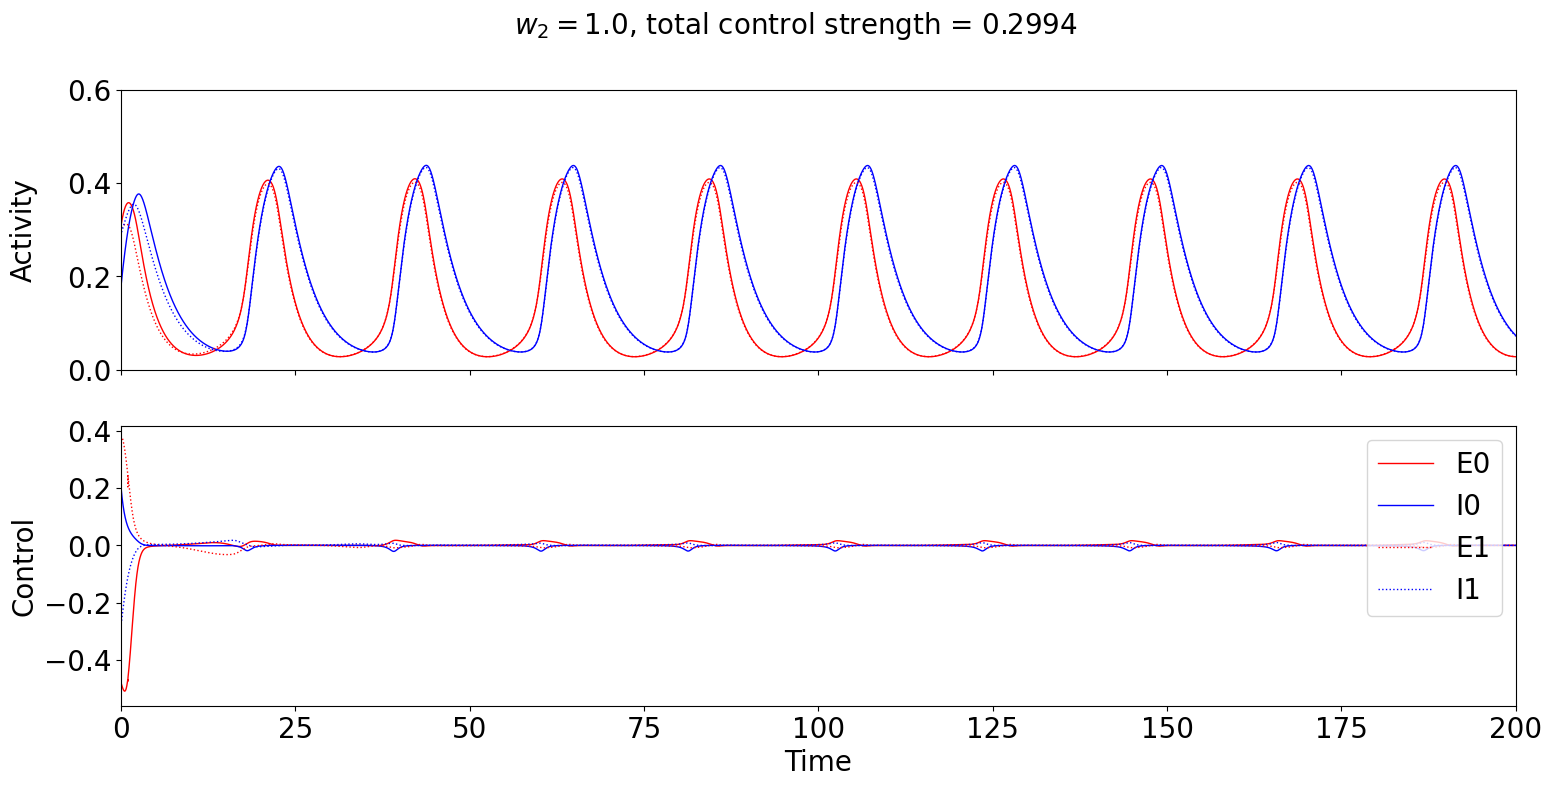

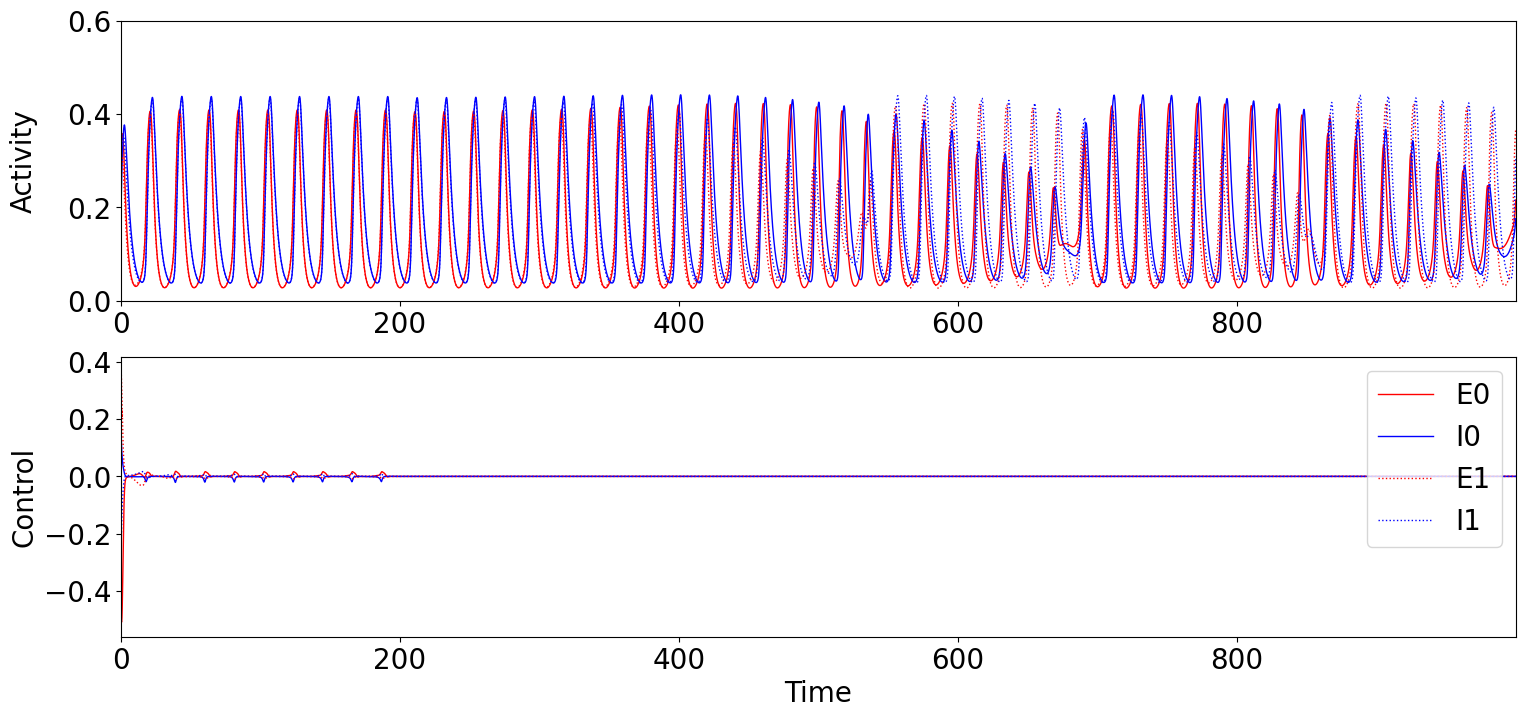

w2 =  100.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -46.61224965073142
Converged in iteration 2 with cost -46.61224965073142
Final cost : -46.61224965073142
Compute control for a deterministic system
Cost in iteration 0: -46.61224965073142
Converged in iteration 19 with cost -46.61224968947683
Final cost : -46.61224968947683
Compute control for a deterministic system
Cost in iteration 0: -46.61224968947683
Converged in iteration 11 with cost -46.61224970095815
Final cost : -46.61224970095815
Compute control for a deterministic system
Cost in iteration 0: -46.61224970095815
Converged in iteration 5 with cost -46.61224970095828
Final cost : -46.61224970095828
Compute control for a deterministic system
Cost in iteration 0: -46.61224970095828
Converged in iteration 2 with cost -46.61224970095828
Final cost : -46.61224970095828
Compute control for a deterministic system
Cost in iteration 0: -46.61224970095828
Converged i

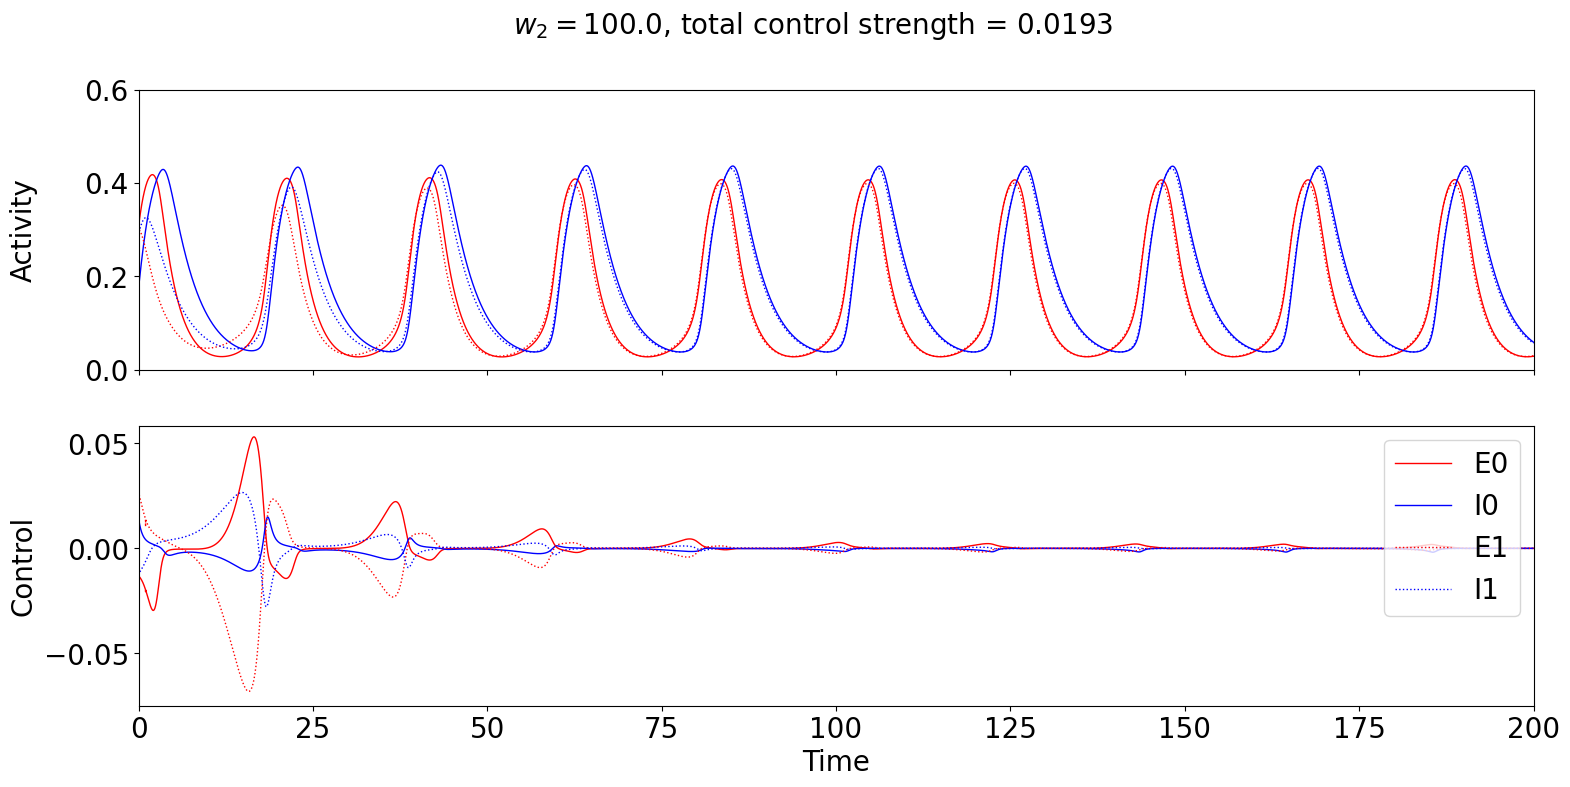

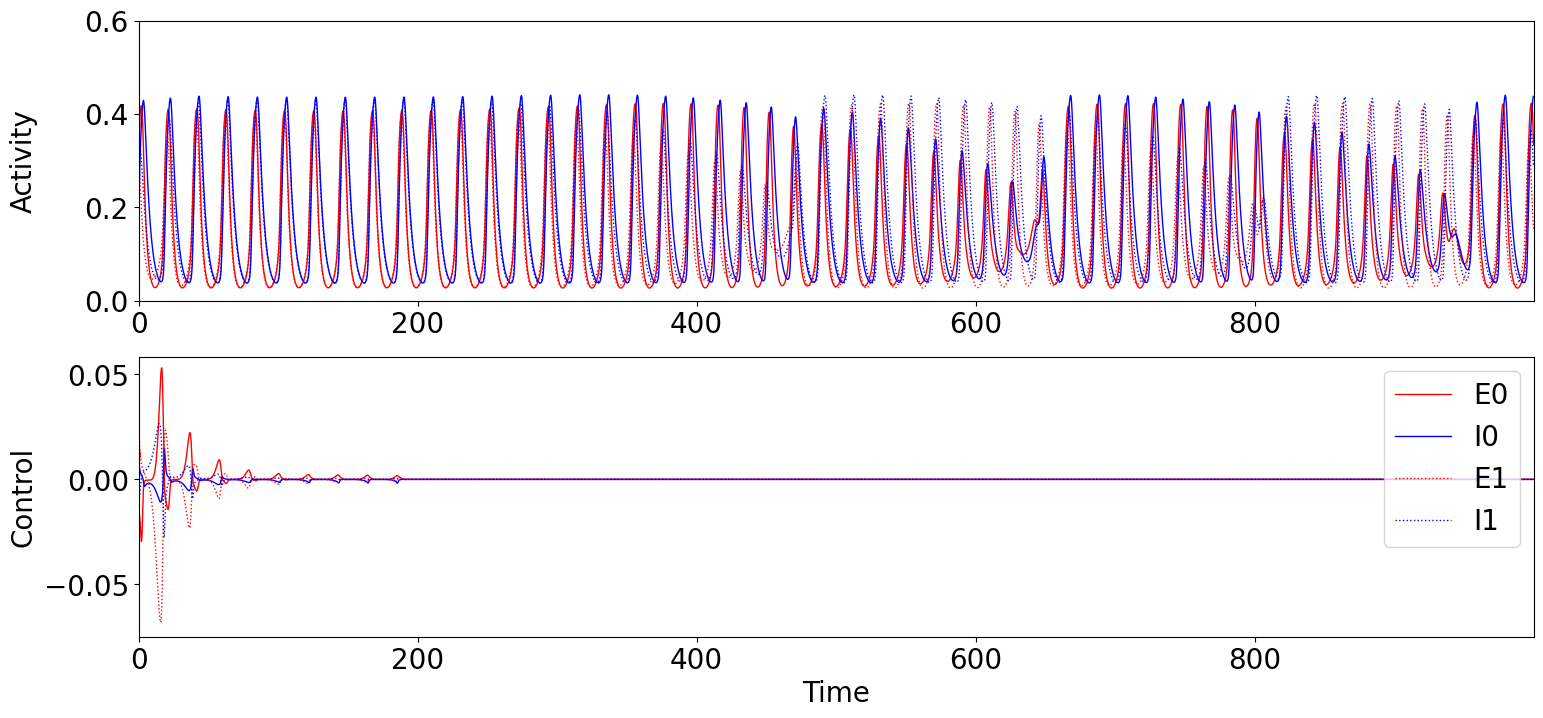

---------------------------------------  VAR
w2 =  0.01
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.0051628547371550286
Cost in iteration 20: 0.00516278611961959
Cost in iteration 40: 0.005157425681417144
Cost in iteration 60: 0.005155344562165748
Cost in iteration 80: 0.005153018312145414
Cost in iteration 100: 0.005147331241757192
Cost in iteration 120: 0.005145591933484861
Cost in iteration 140: 0.005143811339193536
Cost in iteration 160: 0.005141984609705932
Cost in iteration 180: 0.005140289567647281
Cost in iteration 200: 0.005133880493954276
Final cost : 0.005133880493954276
Compute control for a deterministic system
Cost in iteration 0: 0.005133880493954276
Cost in iteration 20: 0.0051328040747172
Cost in iteration 40: 0.005130843227621432
Cost in iteration 60: 0.005129075596687004
Cost in iteration 80: 0.005126078199675549
Cost in iteration 100: 0.0051217615802952934
Cost in iteration 120: 0.00511837655364900

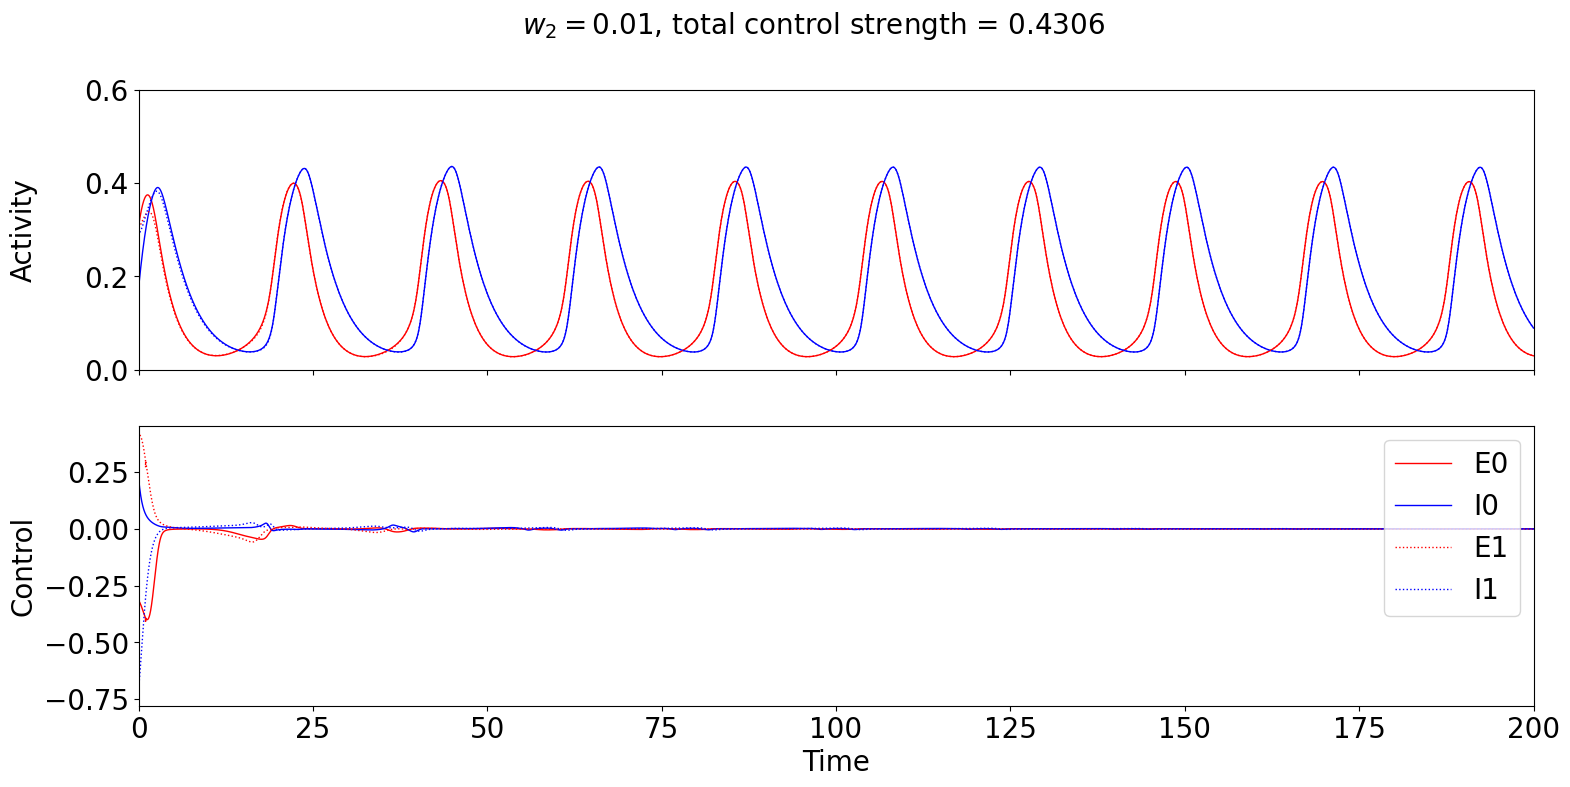

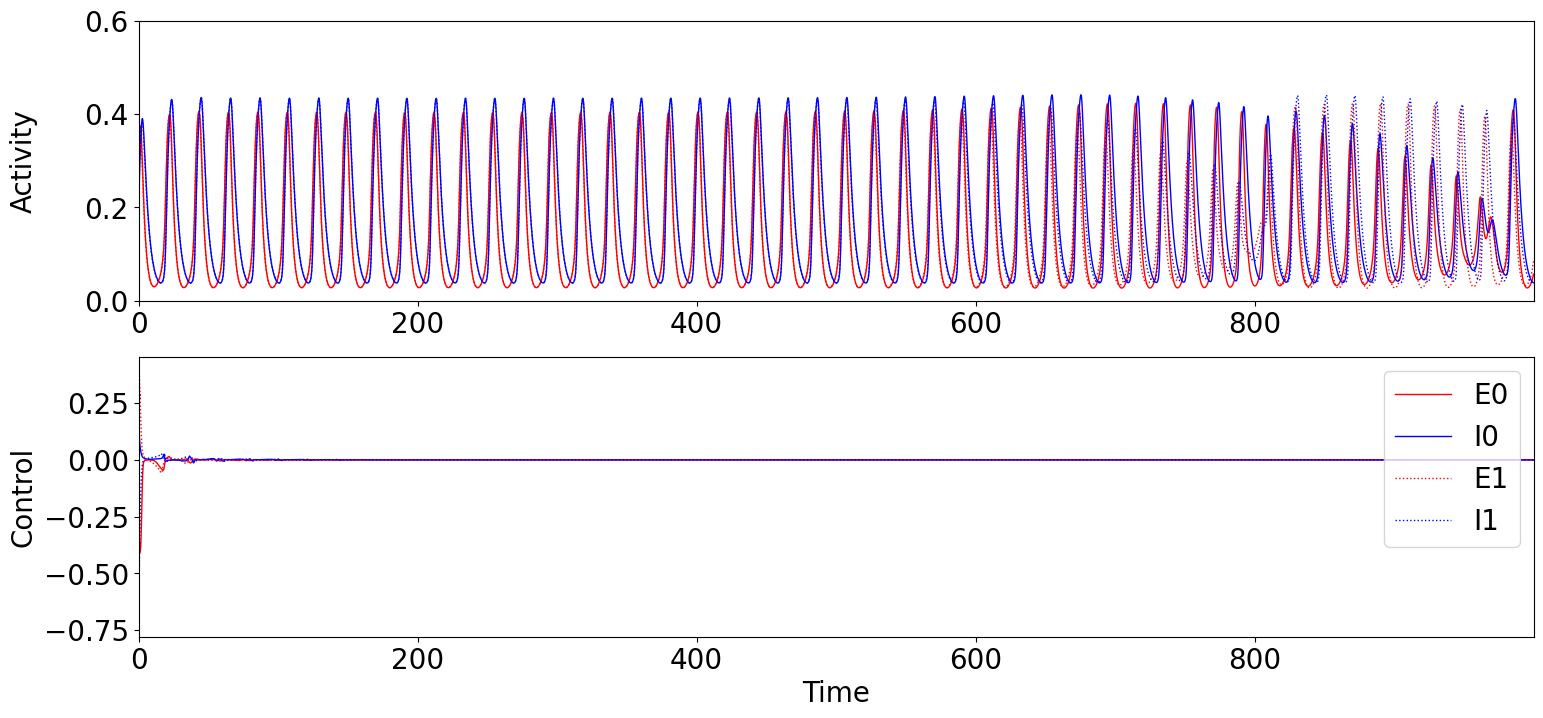

w2 =  1.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.06694735080529807
Converged in iteration 2 with cost 0.06694735080529807
Final cost : 0.06694735080529807
Compute control for a deterministic system
Cost in iteration 0: 0.06694735080529807
Cost in iteration 20: 0.0669473507856414
Cost in iteration 40: 0.06694735076475399
Cost in iteration 60: 0.06694735074635004
Cost in iteration 80: 0.06694735072579239
Cost in iteration 100: 0.06694735070684402
Cost in iteration 120: 0.06694735069012853
Converged in iteration 131 with cost 0.06694735068210154
Final cost : 0.06694735068210154
Compute control for a deterministic system
Cost in iteration 0: 0.06694735068210154
Cost in iteration 20: 0.06694735065626753
Cost in iteration 40: 0.06694735064086685
Cost in iteration 60: 0.06694735061602655
Cost in iteration 80: 0.06694735059068943
Converged in iteration 91 with cost 0.06694735058947004
Final cost : 0.06694735058947004
Com

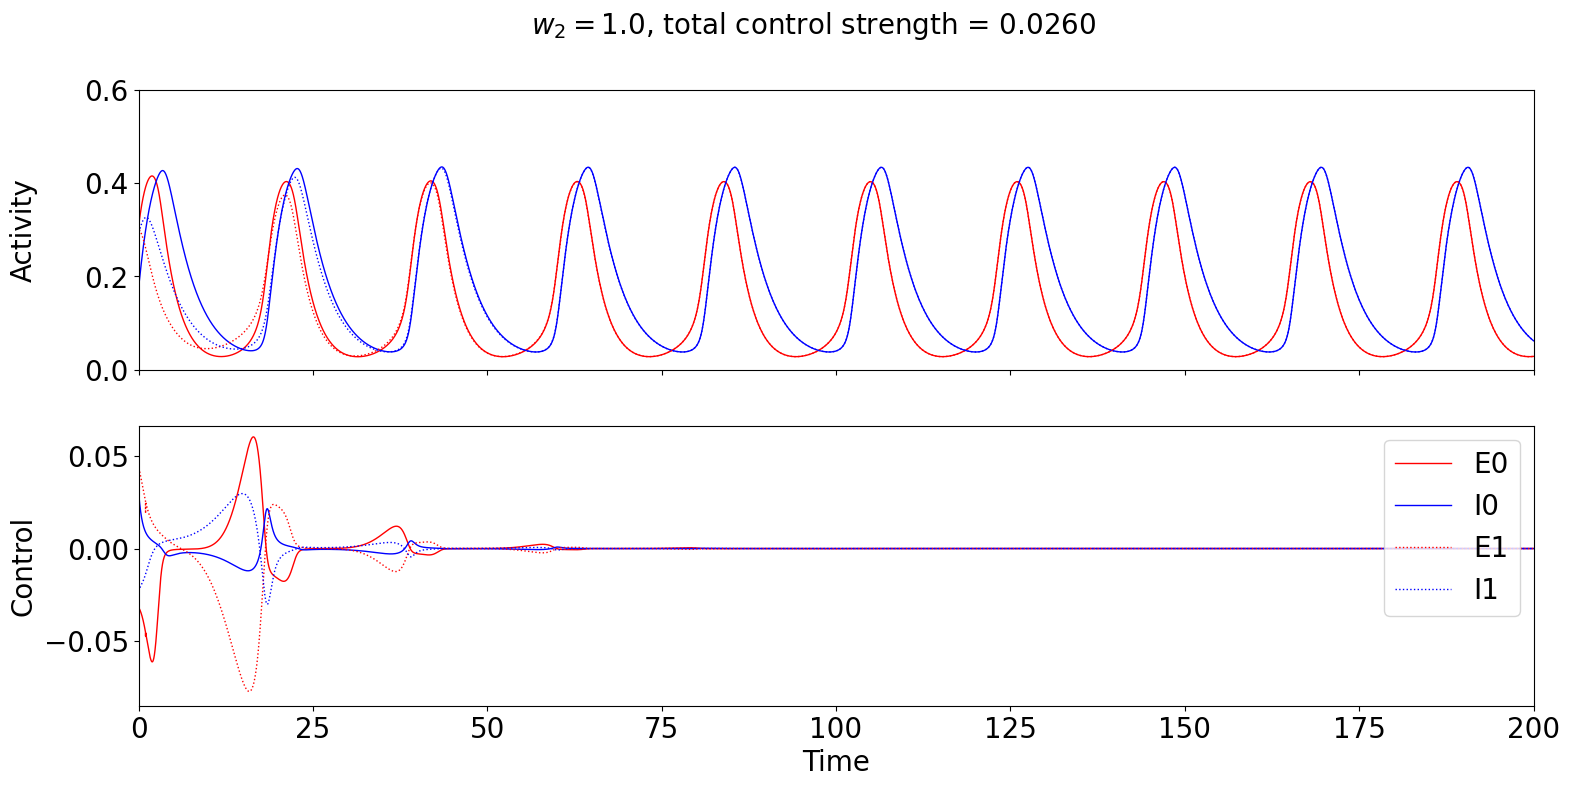

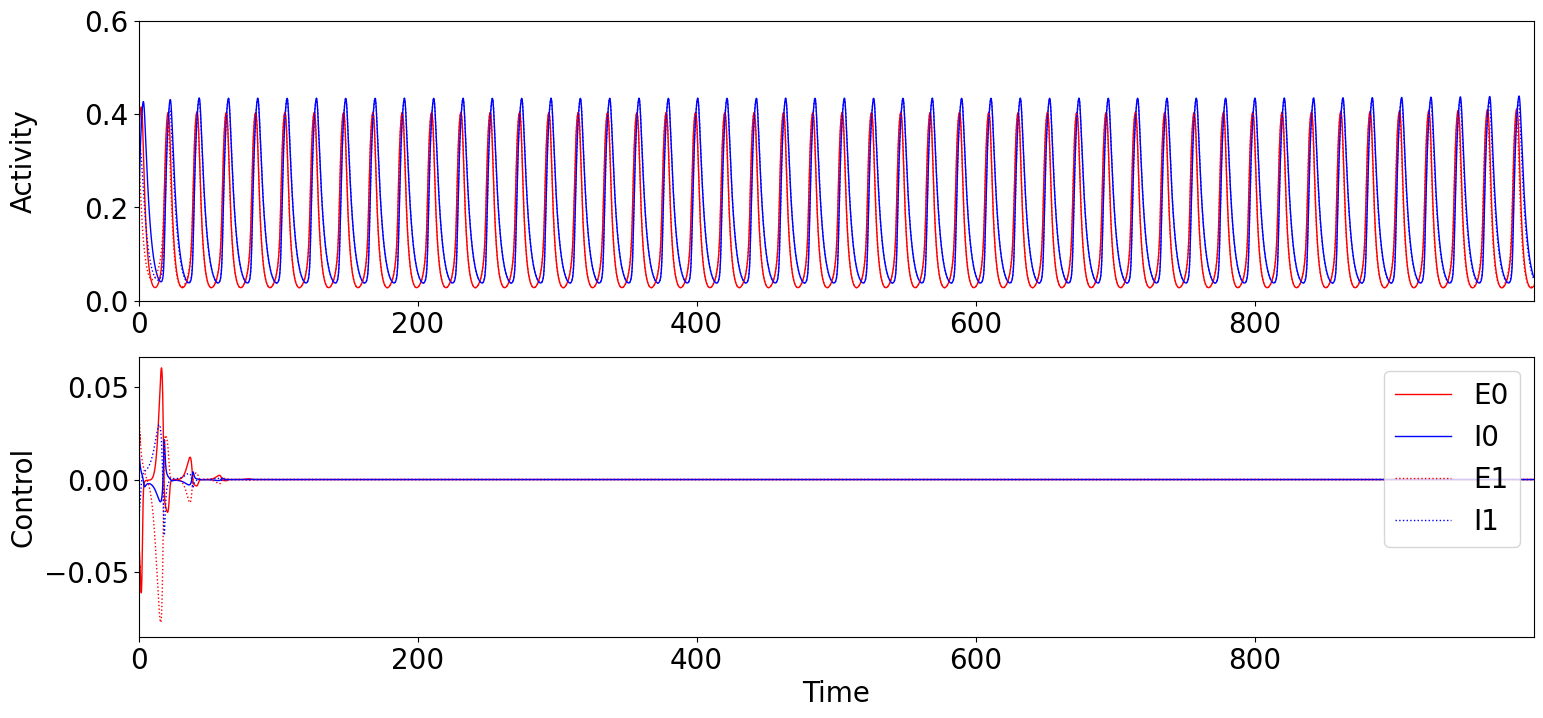

w2 =  100.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.20703703607001112
Converged in iteration 2 with cost 0.20703703607001112
Final cost : 0.20703703607001112
Compute control for a deterministic system
Cost in iteration 0: 0.20703703607001112
Converged in iteration 2 with cost 0.20703703607001112
Final cost : 0.20703703607001112
Compute control for a deterministic system
Cost in iteration 0: 0.20703703607001112
Converged in iteration 2 with cost 0.20703703607001112
Final cost : 0.20703703607001112
Compute control for a deterministic system
Cost in iteration 0: 0.20703703607001112
Converged in iteration 2 with cost 0.20703703607001112
Final cost : 0.20703703607001112
Compute control for a deterministic system
Cost in iteration 0: 0.20703703607001112
Converged in iteration 2 with cost 0.20703703607001112
Final cost : 0.20703703607001112
Compute control for a deterministic system
Cost in iteration 0: 0.207037036070011

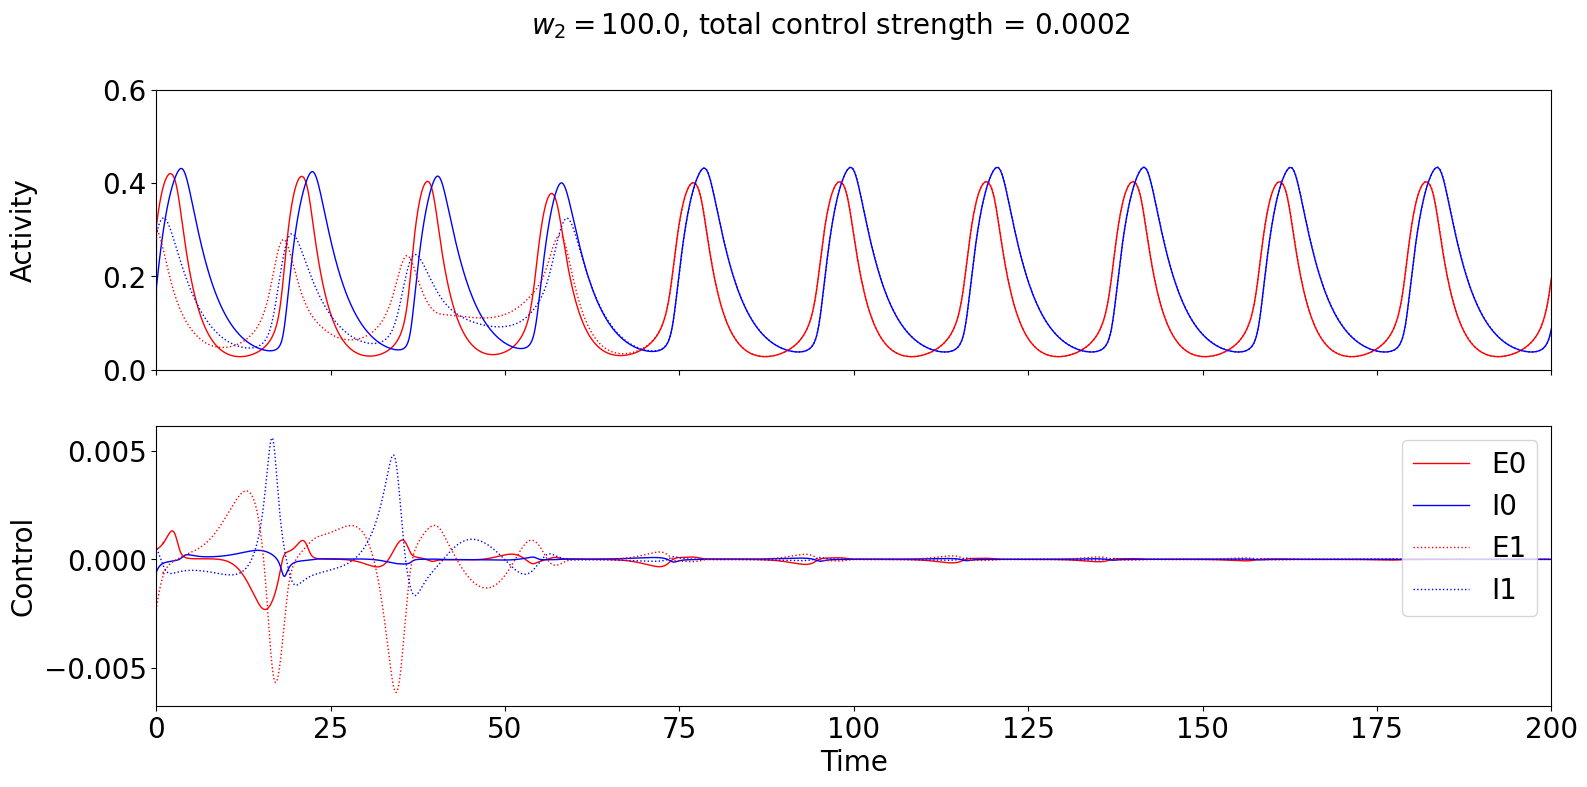

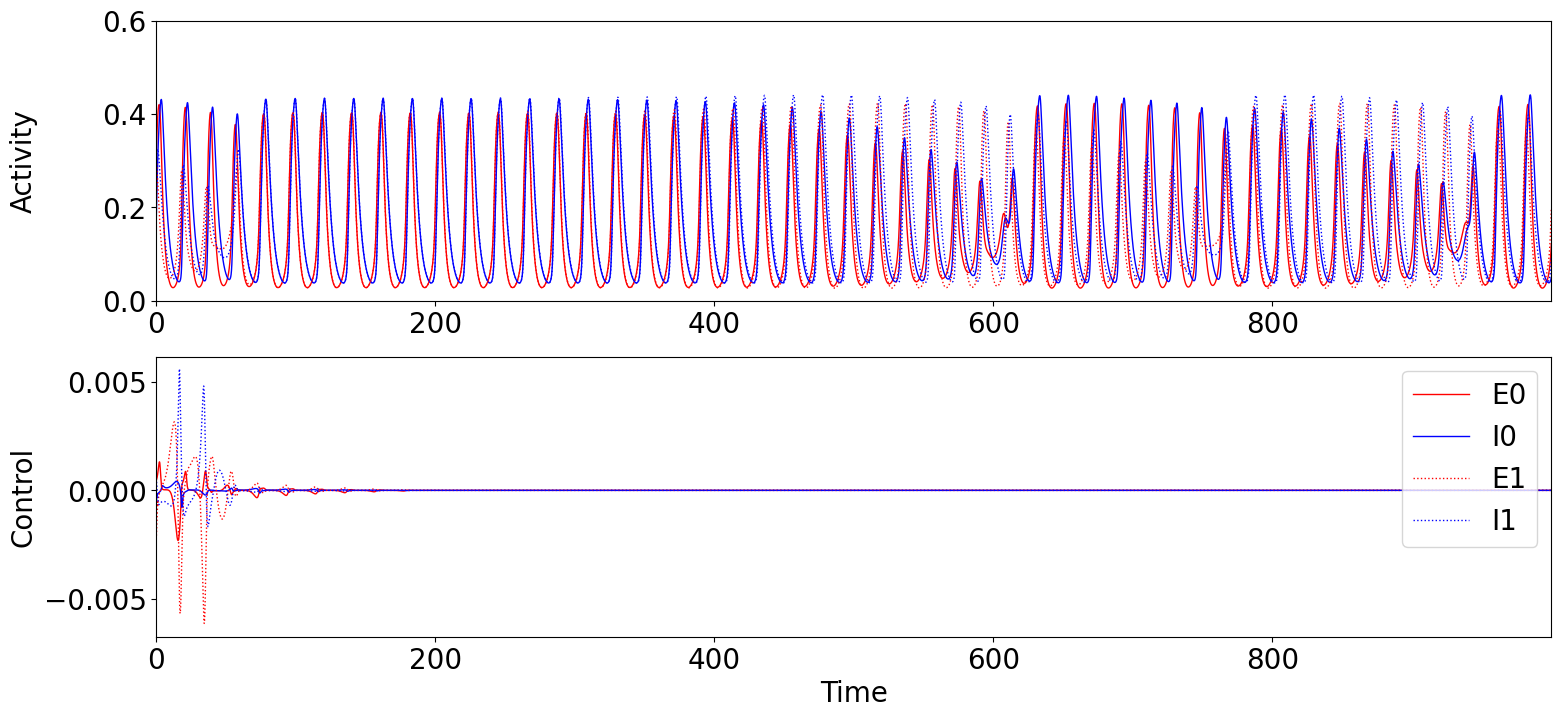

---------------------------------------  F
---------------------------------------  CC
w2 =  0.01
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -49.98488476607068
Cost in iteration 20: -49.98489290802313
Cost in iteration 40: -49.98492124821948
Cost in iteration 60: -49.98495633068931
Cost in iteration 80: -49.98499284244635
Cost in iteration 100: -49.98502917146441
Cost in iteration 120: -49.98506530721836
Cost in iteration 140: -49.98510124855401
Cost in iteration 160: -49.9851369971152
Cost in iteration 180: -49.98517255522456
Cost in iteration 200: -49.985207925261236
Final cost : -49.985207925261236
Compute control for a deterministic system
Cost in iteration 0: -49.985207925261236
Cost in iteration 20: -49.985226880699
Cost in iteration 40: -49.98526916630474
Cost in iteration 60: -49.985311370914566
Cost in iteration 80: -49.98535377957448
Cost in iteration 100: -49.98539629890931
Cost in iteration 120: -49.9854351

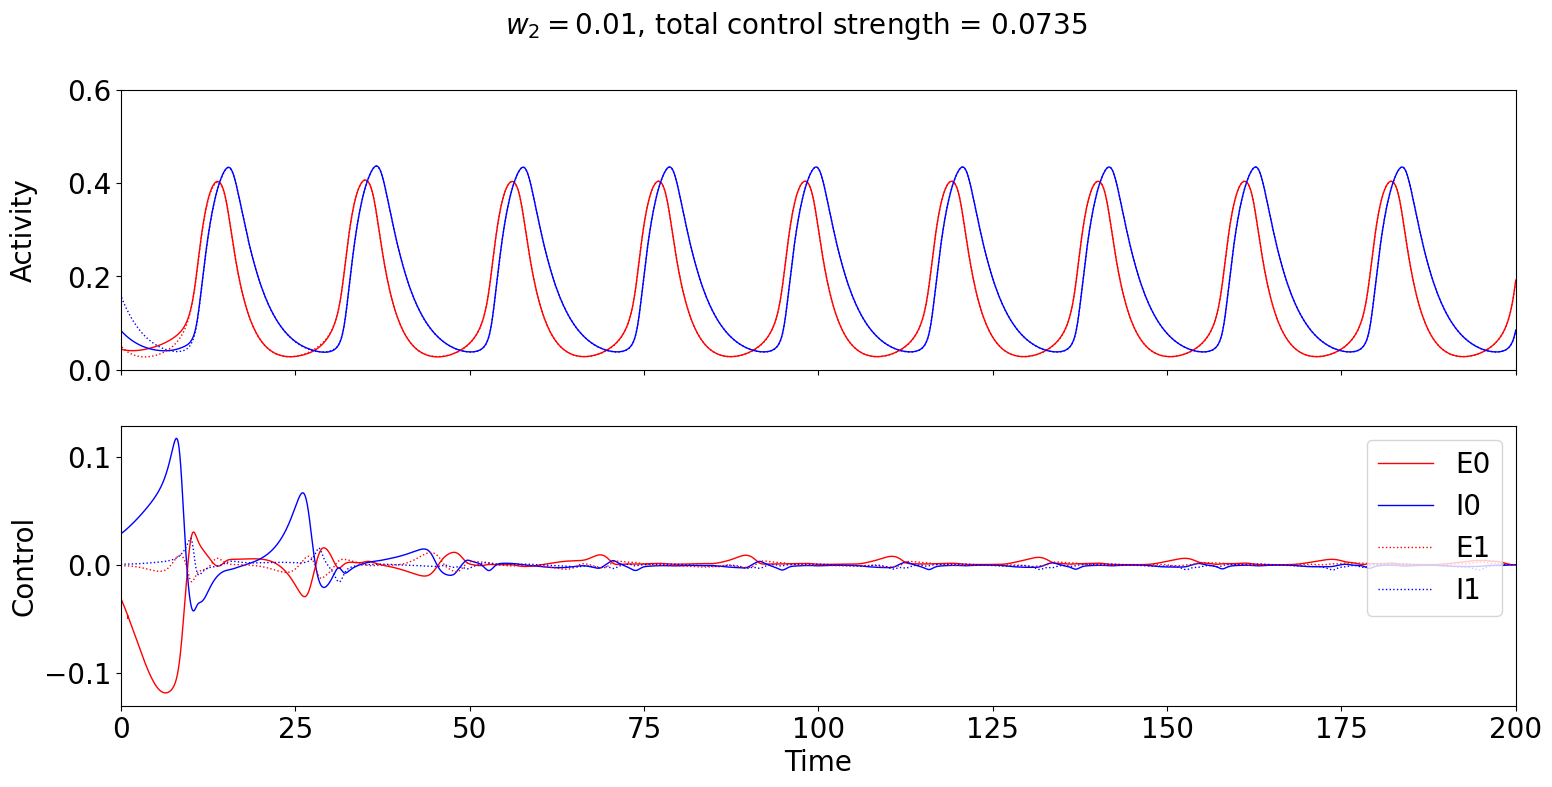

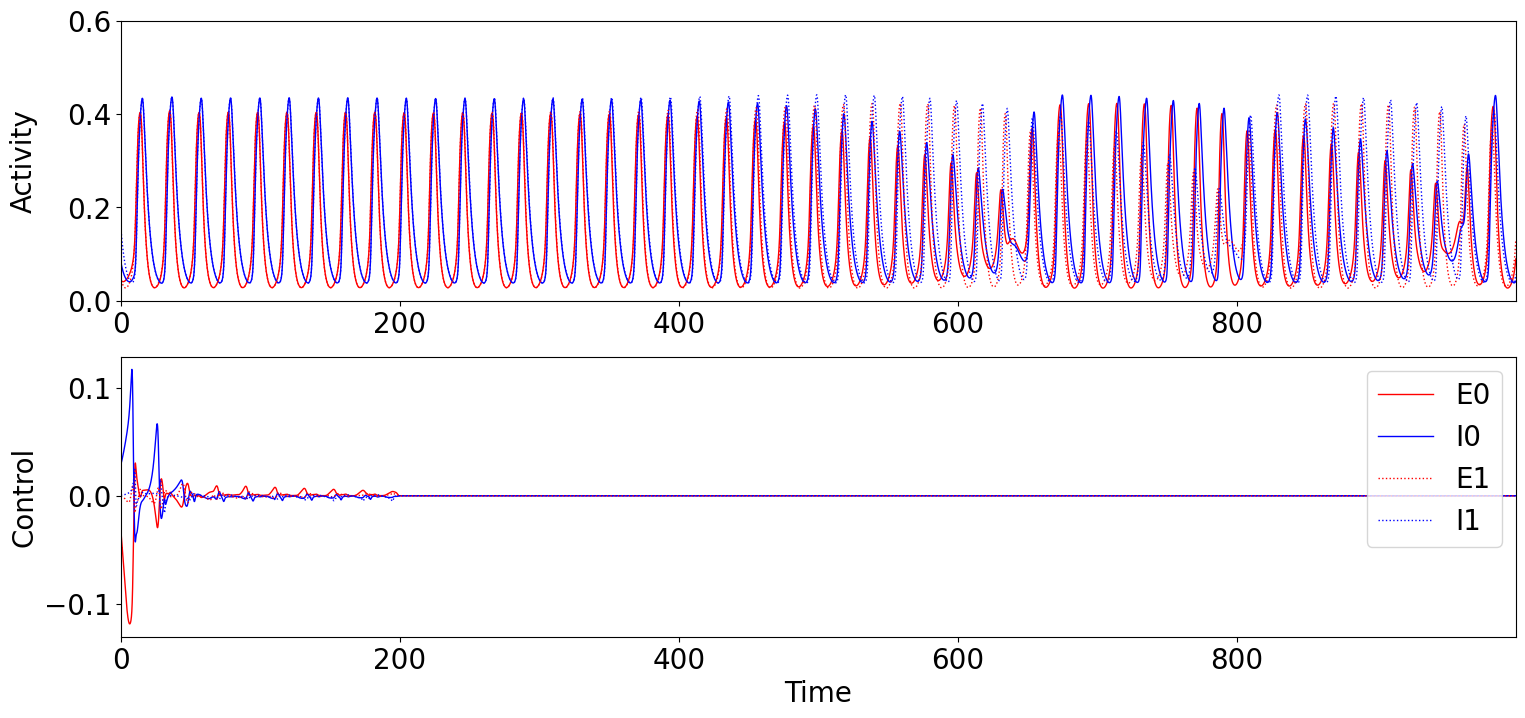

w2 =  1.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -49.94189109517497
Cost in iteration 20: -49.94190216566159
Cost in iteration 40: -49.94216634068751
Cost in iteration 60: -49.94224290374244
Cost in iteration 80: -49.94233387422692
Cost in iteration 100: -49.94242999996715
Cost in iteration 120: -49.94248619301429
Cost in iteration 140: -49.942538696885386
Cost in iteration 160: -49.942590794655565
Cost in iteration 180: -49.94265764061289
Cost in iteration 200: -49.94272493014009
Final cost : -49.94272493014009
Compute control for a deterministic system
Cost in iteration 0: -49.94272493014009
Cost in iteration 20: -49.942752238693124
Cost in iteration 40: -49.94278876465066
Cost in iteration 60: -49.94282575056731
Cost in iteration 80: -49.94287043883681
Cost in iteration 100: -49.94291771545802
Cost in iteration 120: -49.942955464950245
Cost in iteration 140: -49.943009386829715
Cost in iteration 160: -49.9430983

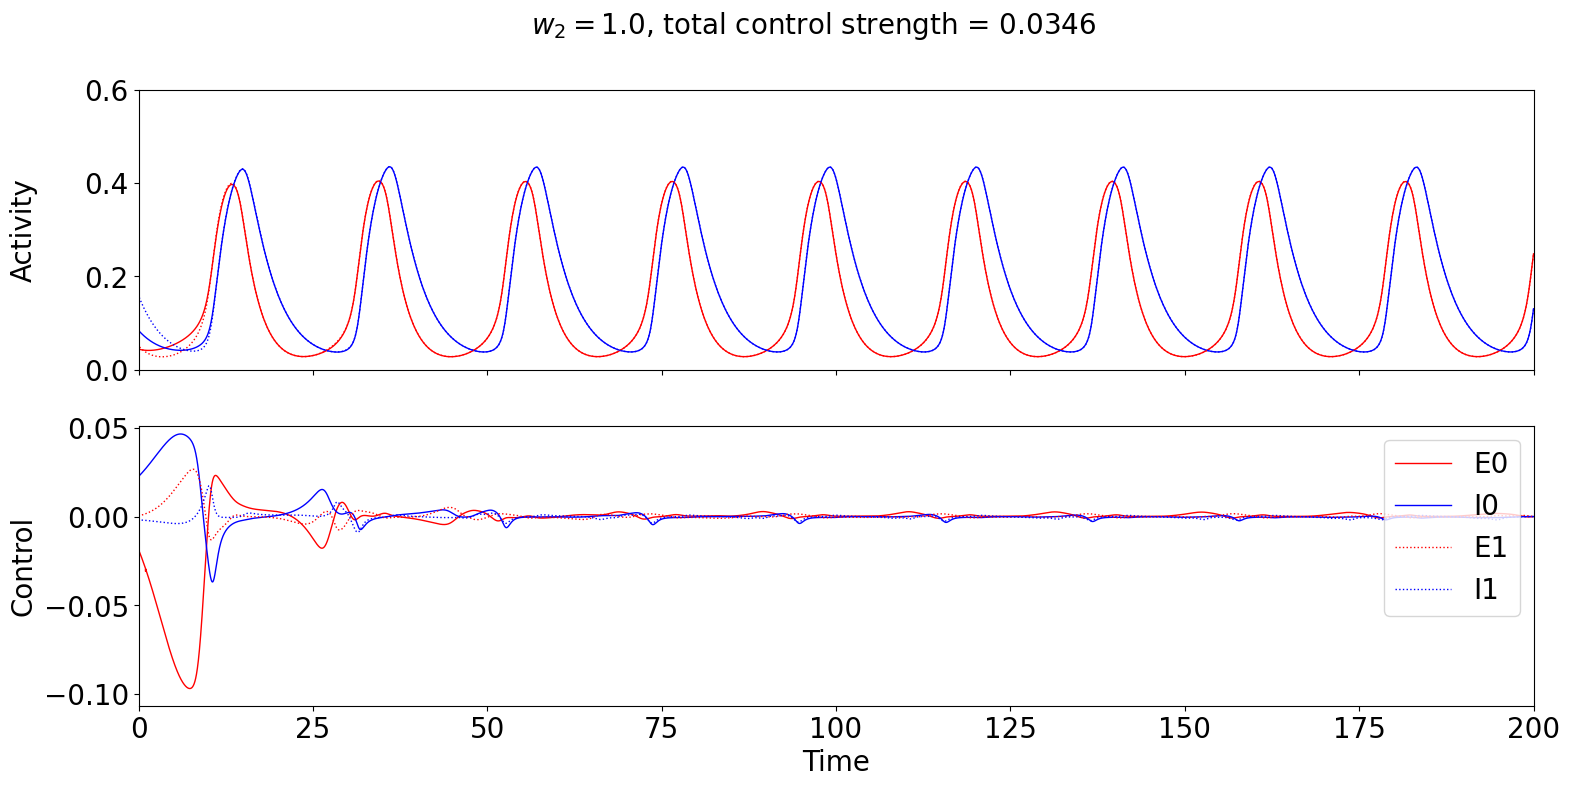

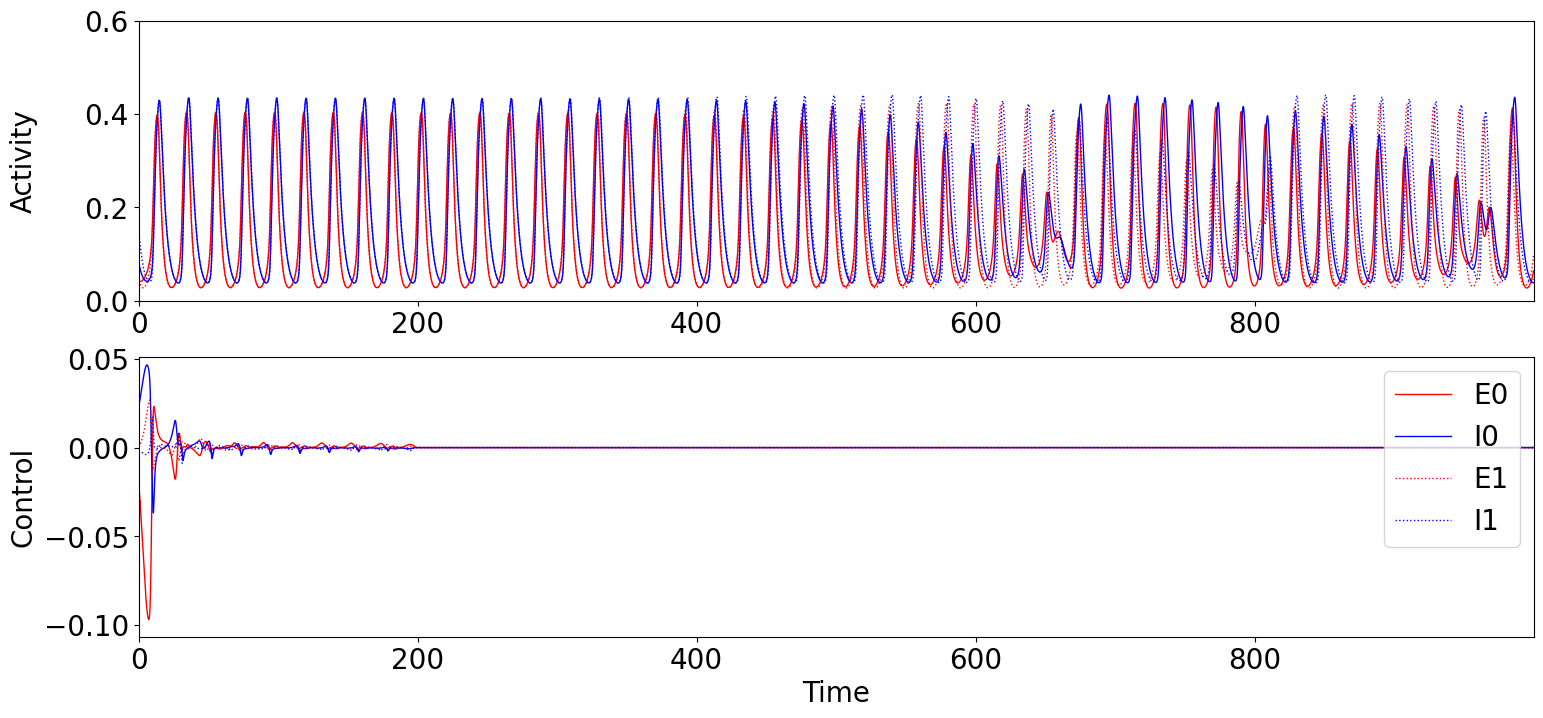

w2 =  100.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -47.04459091412614
Converged in iteration 4 with cost -47.04459091412616
Final cost : -47.04459091412616
Compute control for a deterministic system
Cost in iteration 0: -47.04459091412616
Cost in iteration 20: -47.04459121112144
Cost in iteration 40: -47.04459127881405
Cost in iteration 60: -47.04459142935306
Converged in iteration 62 with cost -47.04459142935306
Final cost : -47.04459142935306
Compute control for a deterministic system
Cost in iteration 0: -47.04459142935306
Converged in iteration 2 with cost -47.04459142935306
Final cost : -47.04459142935306
Compute control for a deterministic system
Cost in iteration 0: -47.04459142935306
Converged in iteration 2 with cost -47.04459142935306
Final cost : -47.04459142935306
Compute control for a deterministic system
Cost in iteration 0: -47.04459142935306
Converged in iteration 2 with cost -47.04459142935306
Fina

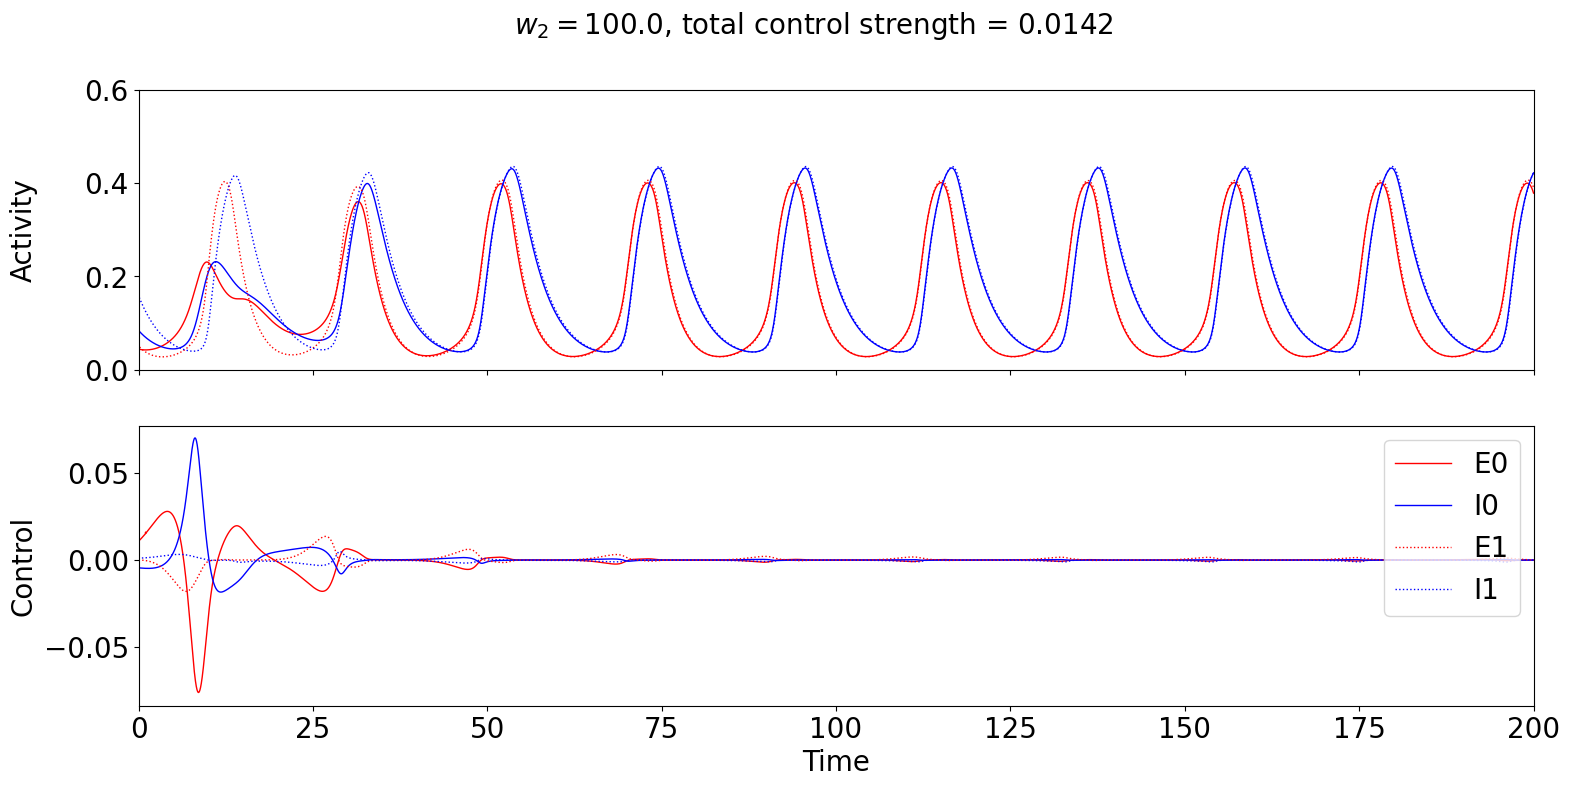

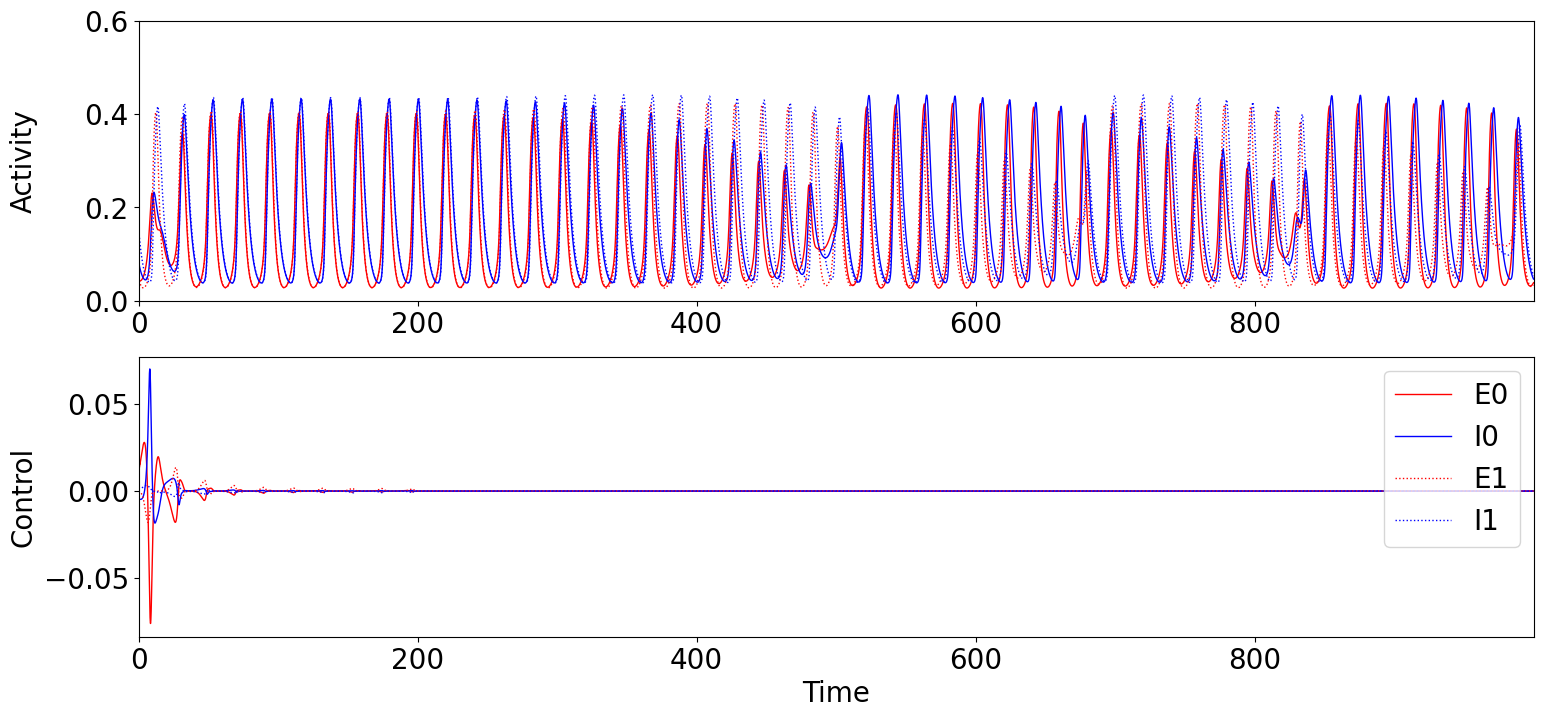

---------------------------------------  VAR
w2 =  0.01
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.001102603888256178
Cost in iteration 20: 0.0011025268054521517
Cost in iteration 40: 0.0011018969023222163
Cost in iteration 60: 0.0011012697306527156
Cost in iteration 80: 0.0011007432976659326
Cost in iteration 100: 0.0011000951734318175
Cost in iteration 120: 0.001099341266095228
Cost in iteration 140: 0.0010987154665242176
Cost in iteration 160: 0.0010981310906873713
Cost in iteration 180: 0.001096956946536073
Cost in iteration 200: 0.001096403177887353
Final cost : 0.001096403177887353
Compute control for a deterministic system
Cost in iteration 0: 0.001096403177887353
Cost in iteration 20: 0.0010960544425504609
Cost in iteration 40: 0.0010941830461717308
Cost in iteration 60: 0.001092909217724083
Cost in iteration 80: 0.0010917066519844916
Cost in iteration 100: 0.0010910412137069342
Cost in iteration 120: 0.00109

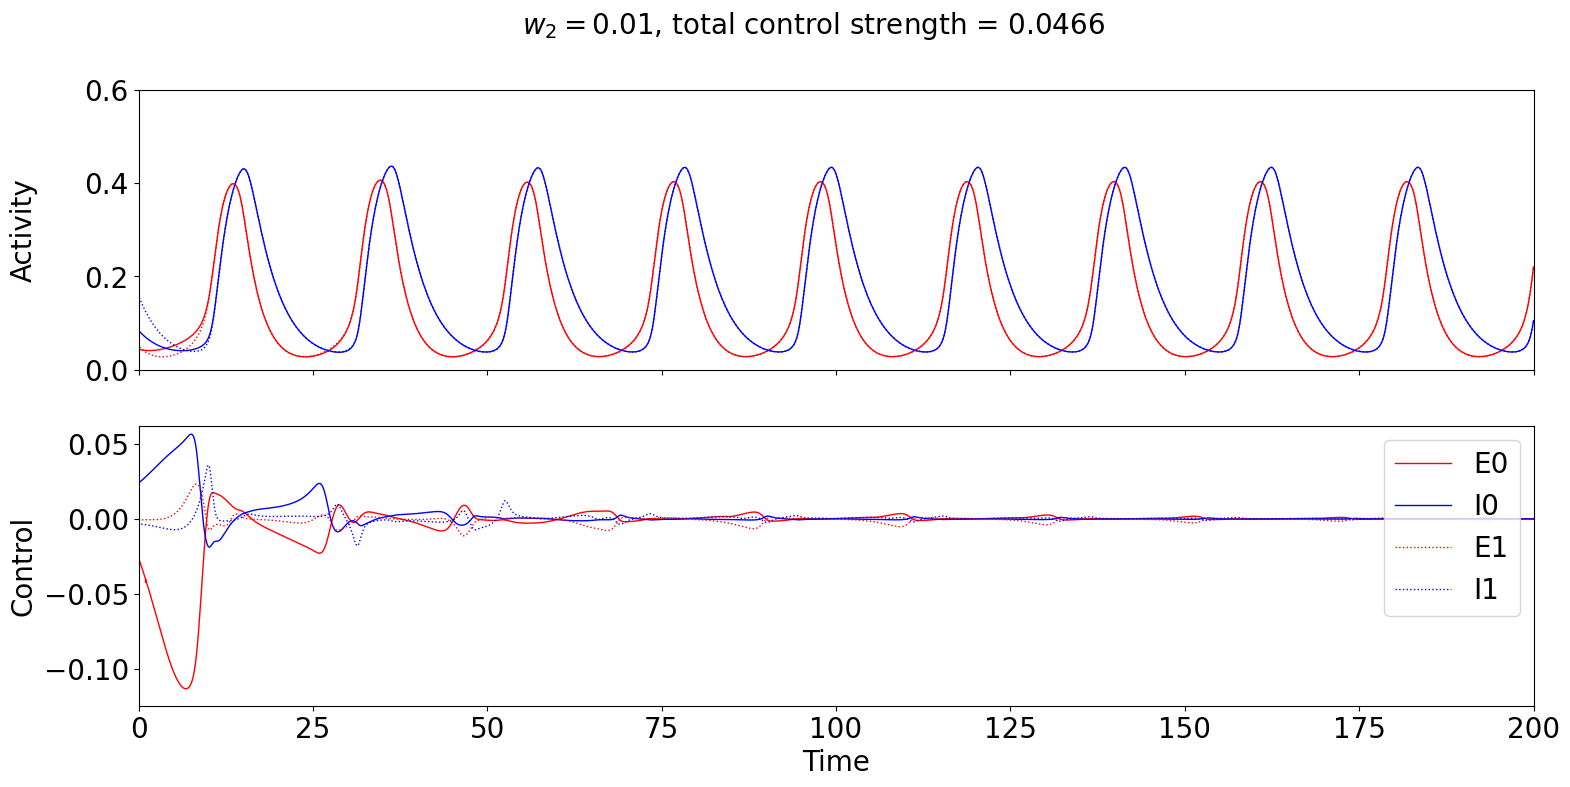

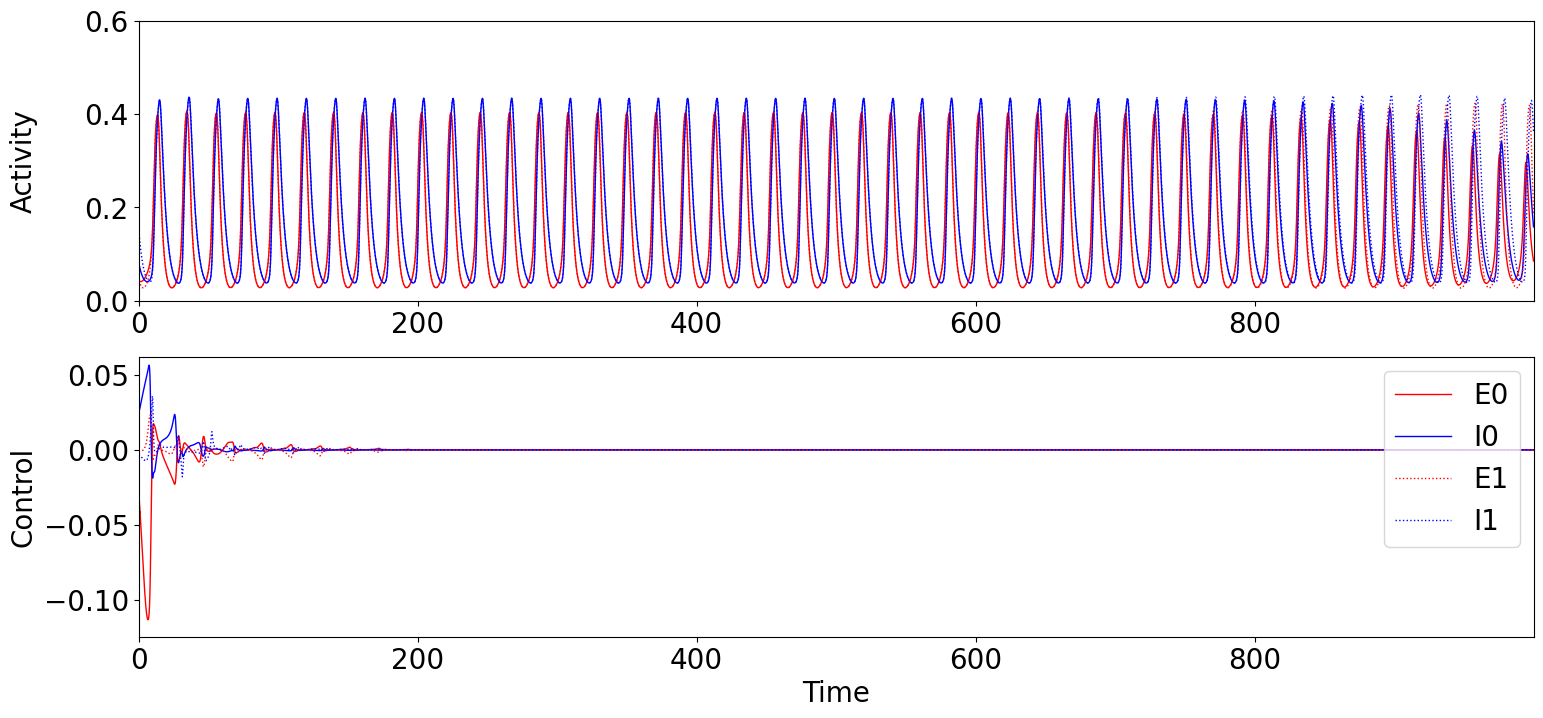

w2 =  1.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.022873029847388985
Converged in iteration 2 with cost 0.022873029847388985
Final cost : 0.022873029847388985
Compute control for a deterministic system
Cost in iteration 0: 0.022873029847388985
Cost in iteration 20: 0.02287302983166305
Cost in iteration 40: 0.022873029804689297
Cost in iteration 60: 0.02287302977783422
Cost in iteration 80: 0.02287302975109236
Cost in iteration 100: 0.022873029724461657
Cost in iteration 120: 0.022873029697936524
Cost in iteration 140: 0.022873029671514496
Cost in iteration 160: 0.02287302964519113
Cost in iteration 180: 0.022873029618963647
Cost in iteration 200: 0.02287302959282872
Final cost : 0.02287302959282872
Compute control for a deterministic system
Cost in iteration 0: 0.02287302959282872
Cost in iteration 20: 0.022873029578487122
Cost in iteration 40: 0.022873029563615737
Cost in iteration 60: 0.022873029548868263
Cost i

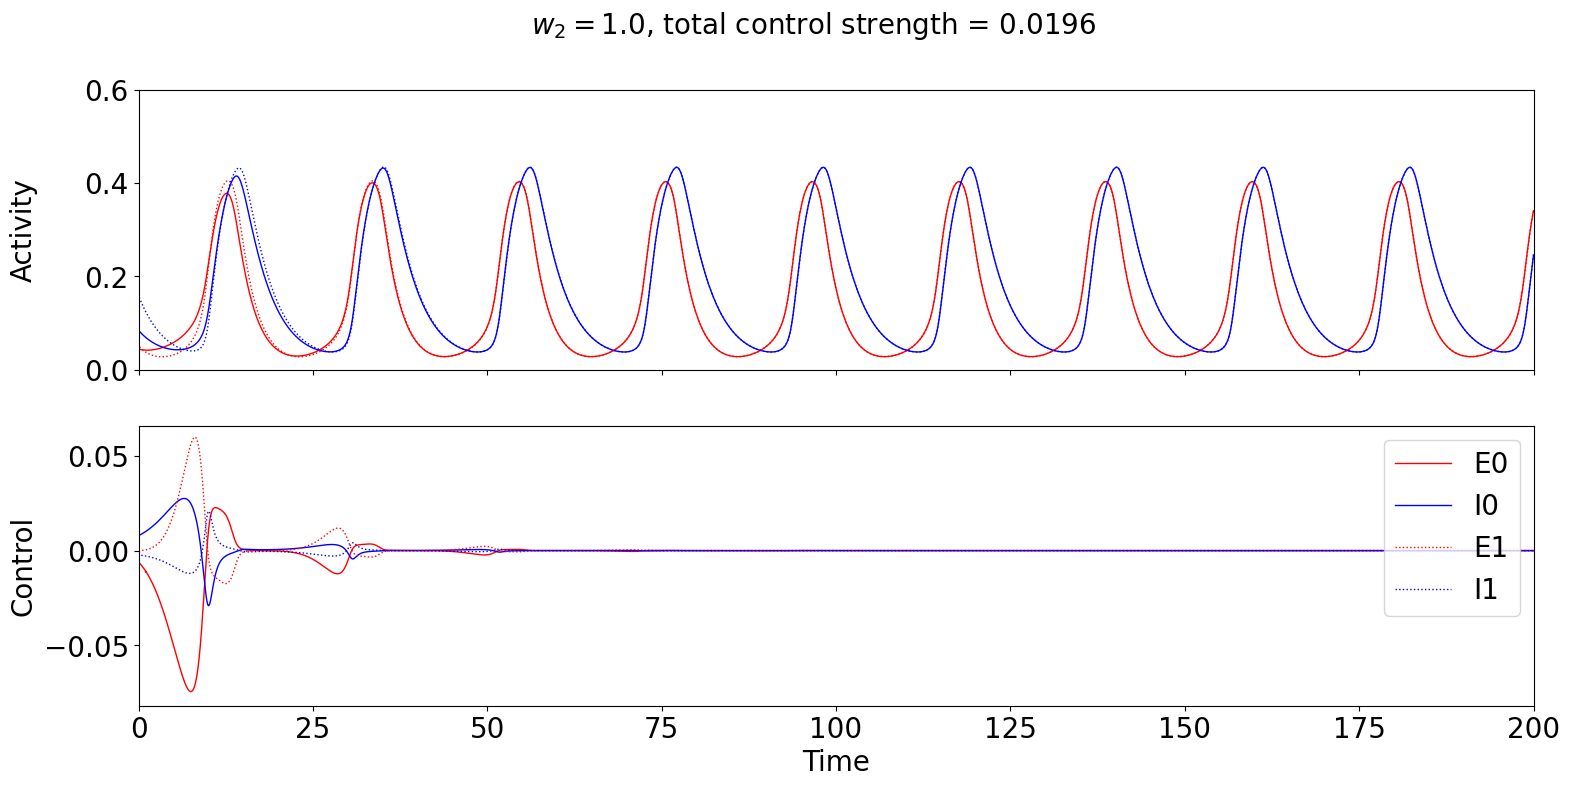

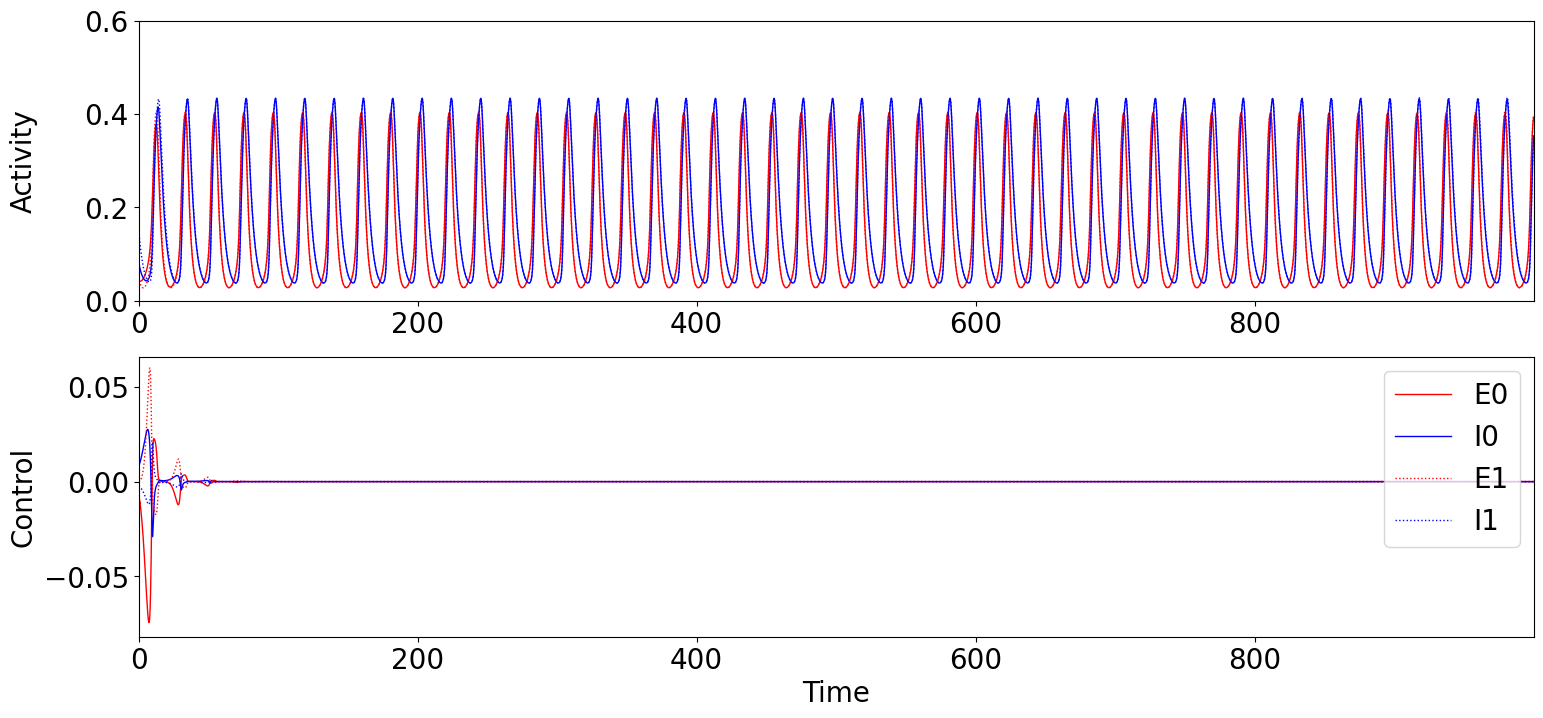

w2 =  100.0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.20227237502310855
Converged in iteration 2 with cost 0.20227237502310855
Final cost : 0.20227237502310855
Compute control for a deterministic system
Cost in iteration 0: 0.20227237502310855
Converged in iteration 18 with cost 0.20227237495054307
Final cost : 0.20227237495054307
Compute control for a deterministic system
Cost in iteration 0: 0.20227237495054307
Converged in iteration 7 with cost 0.20227237495054182
Final cost : 0.20227237495054182
Compute control for a deterministic system
Cost in iteration 0: 0.20227237495054182
Converged in iteration 2 with cost 0.20227237495054182
Final cost : 0.20227237495054182
Compute control for a deterministic system
Cost in iteration 0: 0.20227237495054182
Converged in iteration 7 with cost 0.20227237495054123
Final cost : 0.20227237495054123
Compute control for a deterministic system
Cost in iteration 0: 0.20227237495054

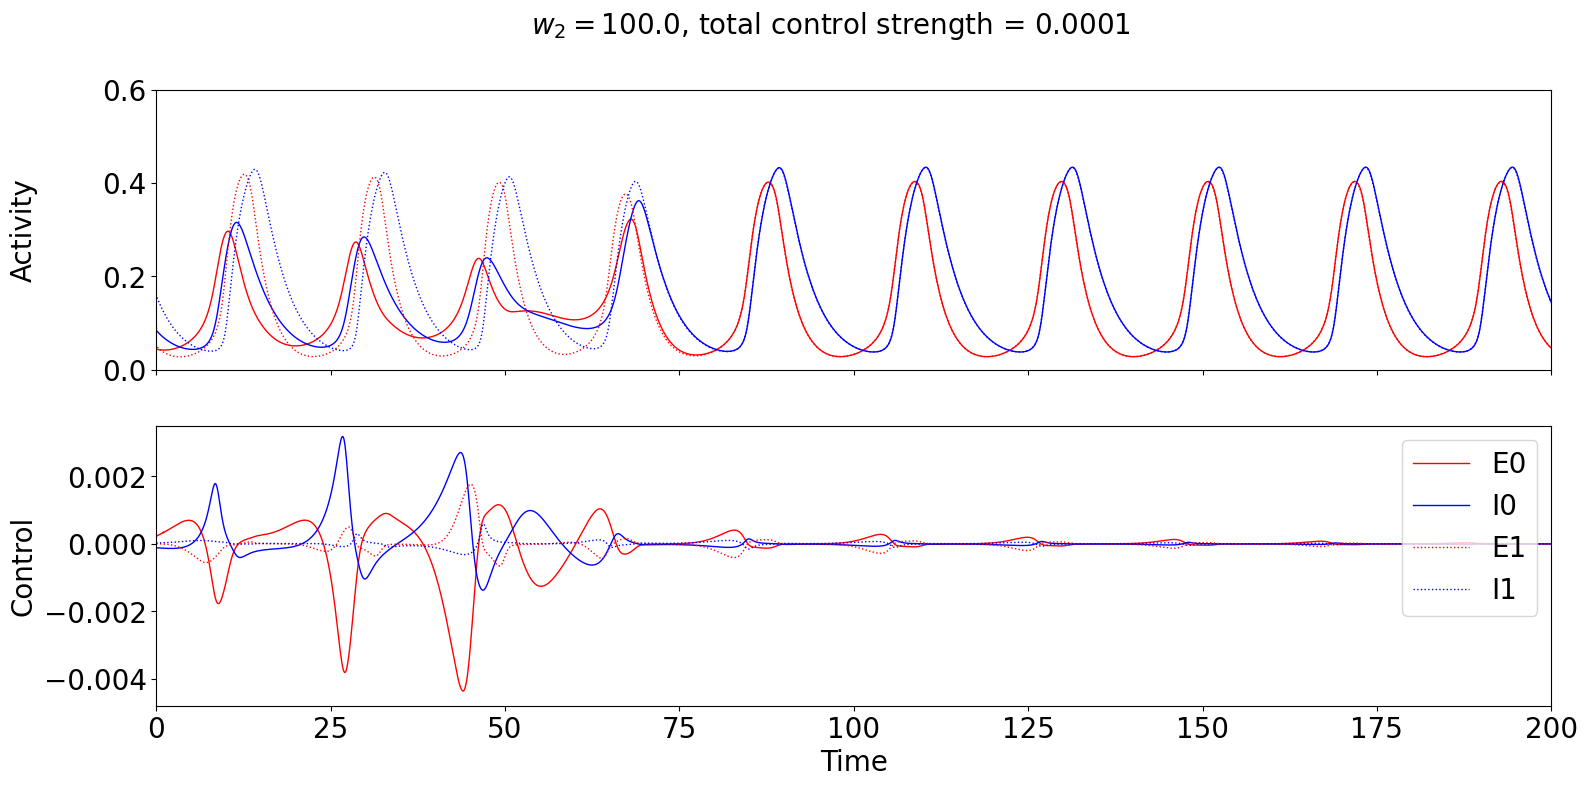

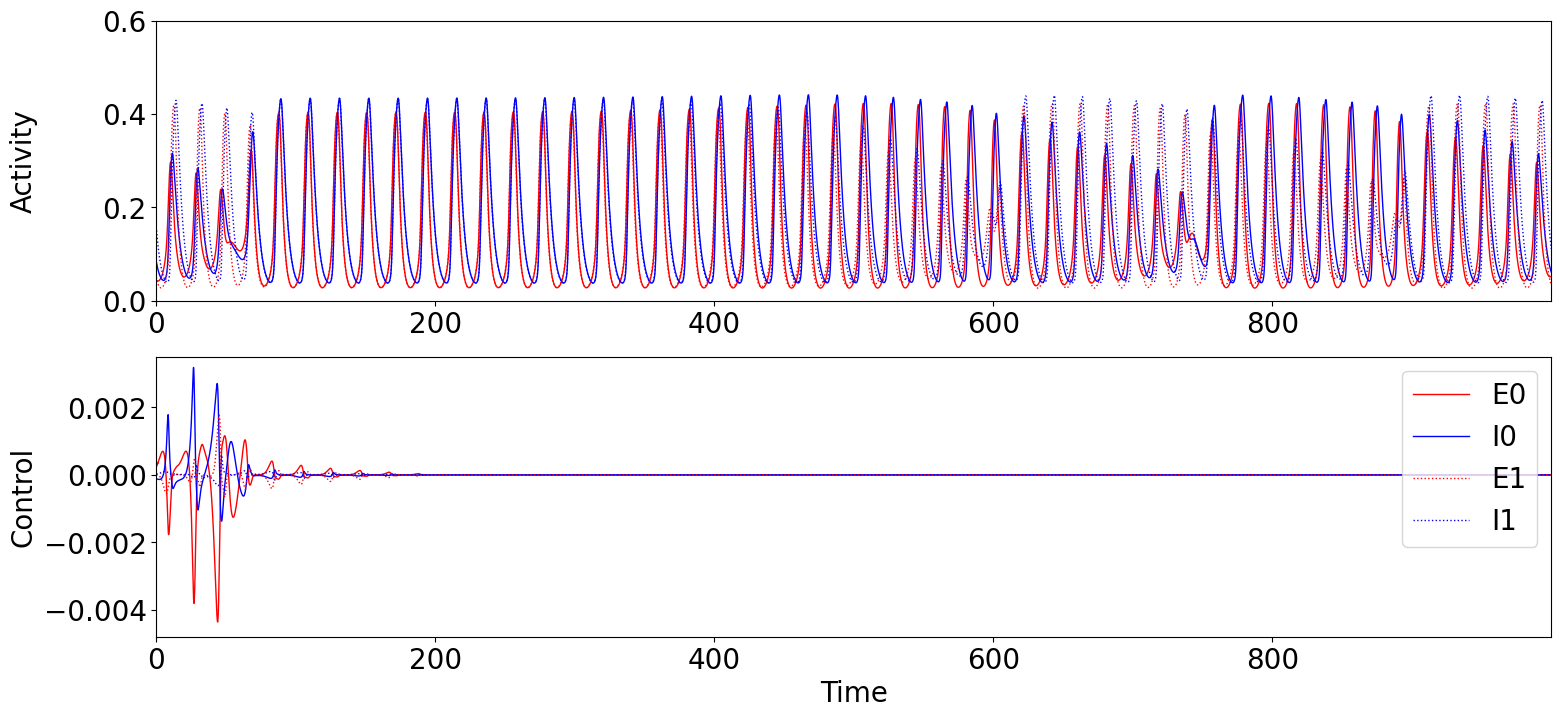

In [129]:
#### initial condition 0
it = 200

model = WCModel(Cmat=cmat, Dmat=points[0][2]*20.*cmat)

model.params['duration'] = duration
model.params.dt = dt
model.params.exc_ext_baseline = points[0][0]
model.params.inh_ext_baseline = points[0][1]
model.params.K_gl = coupling

zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))
model.params["exc_ext"] = zero_control[:,0,:]
model.params["inh_ext"] = zero_control[:,1,:]

for init_ind in range(2):

    model.params["exc_init"] = data["init"][init_ind][0]
    model.params["inh_init"] = data["init"][init_ind][1]

    model.run()

    for mi, method in enumerate(["F", "CC", "VAR"]):

        print("--------------------------------------- ", method)

        if mi not in [1,2]: continue

        for wi, w2 in enumerate(data["weights"][mi,init_ind,:]):

            print("w2 = ",w2)

            #if wi not in [0]: continue

            #for factor in np.random.random(1):
            for factor in [1]:

                model_controlled = oc_wc.OcWc(model, period, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                            cost_matrix=costmat, control_matrix=controlmat)
                
                model_controlled.weights["w_p"] = 0.
                model_controlled.weights["w_2"] = w2 * factor
                if method == "F":
                    model_controlled.weights["w_f_sync"] = 1.
                elif method == "CC":
                    model_controlled.weights["w_cc"] = 1.
                elif method == "VAR":
                    model_controlled.weights["w_var"] = 1.

                model_controlled.maximum_control_strength = maxstr

                if True:
                    if type(data["control"][mi][init_ind][wi]) != type(None):
                        model_controlled.control = data["control"][mi][init_ind][wi].copy()
                        model_controlled.update_input()

                for j in range(1):
                    model_controlled.grad_method = 0
                    model_controlled.channelwise_optimization = True

                    for l in range(1):
                        for k in np.arange(-9., 9., 2.):
                            model_controlled.zero_step_encountered = False
                            model_controlled.step = 10**(k)
                            model_controlled.optimize(it)

                    model_controlled.grad_method = 1
                    model_controlled.channelwise_optimization = True

                    for l in range(0):
                        for k in np.arange(-9., 9., 2.):
                            model_controlled.zero_step_encountered = False
                            model_controlled.step = 10**(k)
                            model_controlled.optimize(10)

                data["control"][mi][init_ind][wi] = model_controlled.control.copy()
                data["state"][mi][init_ind][wi] = model_controlled.get_xs()

            if True:
                mod = copy.deepcopy(model_controlled.model)
                mod.params.duration = 1000.
                input = np.zeros((2,2,1+int(mod.params.duration/dt)))
                input[:,:,:1+int(duration/dt)] = model_controlled.control.copy()
                mod.params.exc_ext = input[:,0,:]
                mod.params.inh_ext = input[:,1,:]
                mod.run()

                plot_c = input.copy()
                plot_s = np.concatenate( (mod.exc[:,np.newaxis,:], mod.inh[:,np.newaxis,:]), axis=1 )

            coc = cost_functions.control_strength_cost(data["control"][mi][init_ind][wi], weights, dt)
            data["control_cost"][mi, init_ind, wi] = coc
            data["sync_cost"][mi, init_ind, wi] = model_controlled.cost_history[-1] - w2 * coc

            filename = "syncbeat_" + str(mi) + "_" + str(init_ind) + "_" + str(wi) + ".png"
            title = r"$w_2 = $" + "{}".format(w2) + ", total control strength = {:.4f}".format(coc)
            filename1 = "syncbeat_" + str(mi) + "_" + str(init_ind) + "_" + str(wi) + "_long.png"

            print("cost of control = ", coc)
            plot_control(data["control"][mi][init_ind][wi], data["state"][mi][init_ind][wi], duration, dt, filename=os.path.join(dir,filename), title=title)
            plot_control(plot_c[:,:,1:], plot_s, mod.params.duration-dt, dt, filename=os.path.join(dir,filename1))

        with open(os.path.join(pickledir, '2n_wc_oscillations_cc.pickle'), 'wb') as f:
            pickle.dump(data, f)

In [128]:
latex_str_coc = ""
latex_str_cos = ""

for wi, label in enumerate(["small $w_2$", "intermediate $w_2$", "large $w_2$"]):
    latex_str_coc = latex_str_coc + label
    latex_str_cos = latex_str_cos + label
    for mi in range(3):
        for ii in range(2):
            latex_str_coc = latex_str_coc + " & {:.4f}".format(data["control_cost"][mi, ii, wi])
            latex_str_cos = latex_str_cos + " & {:.4f}".format(data["sync_cost"][mi, ii, wi])
    latex_str_coc = latex_str_coc + " \\\\ "
    latex_str_cos = latex_str_cos + " \\\\ "

print(latex_str_coc)
print(latex_str_cos)

small $w_2$ & 0.5387 & 0.0000 & 0.6724 & 0.0689 & 0.4440 & 0.0458 \\ intermediate $w_2$ & 0.0076 & 0.0000 & 0.2978 & 0.0365 & 0.0260 & 0.0196 \\ large $w_2$ & 0.0002 & 0.0000 & 0.0193 & 0.0142 & 0.0002 & 0.0001 \\ 
small $w_2$ & -0.0322 & 0.0000 & -49.9990 & -49.9856 & 0.0007 & 0.0006 \\ intermediate $w_2$ & -0.0208 & 0.0000 & -49.9296 & -49.9784 & 0.0410 & 0.0032 \\ large $w_2$ & -0.0183 & 0.0000 & -48.5438 & -48.4664 & 0.1893 & 0.1932 \\ 


Point  Osc
50.0


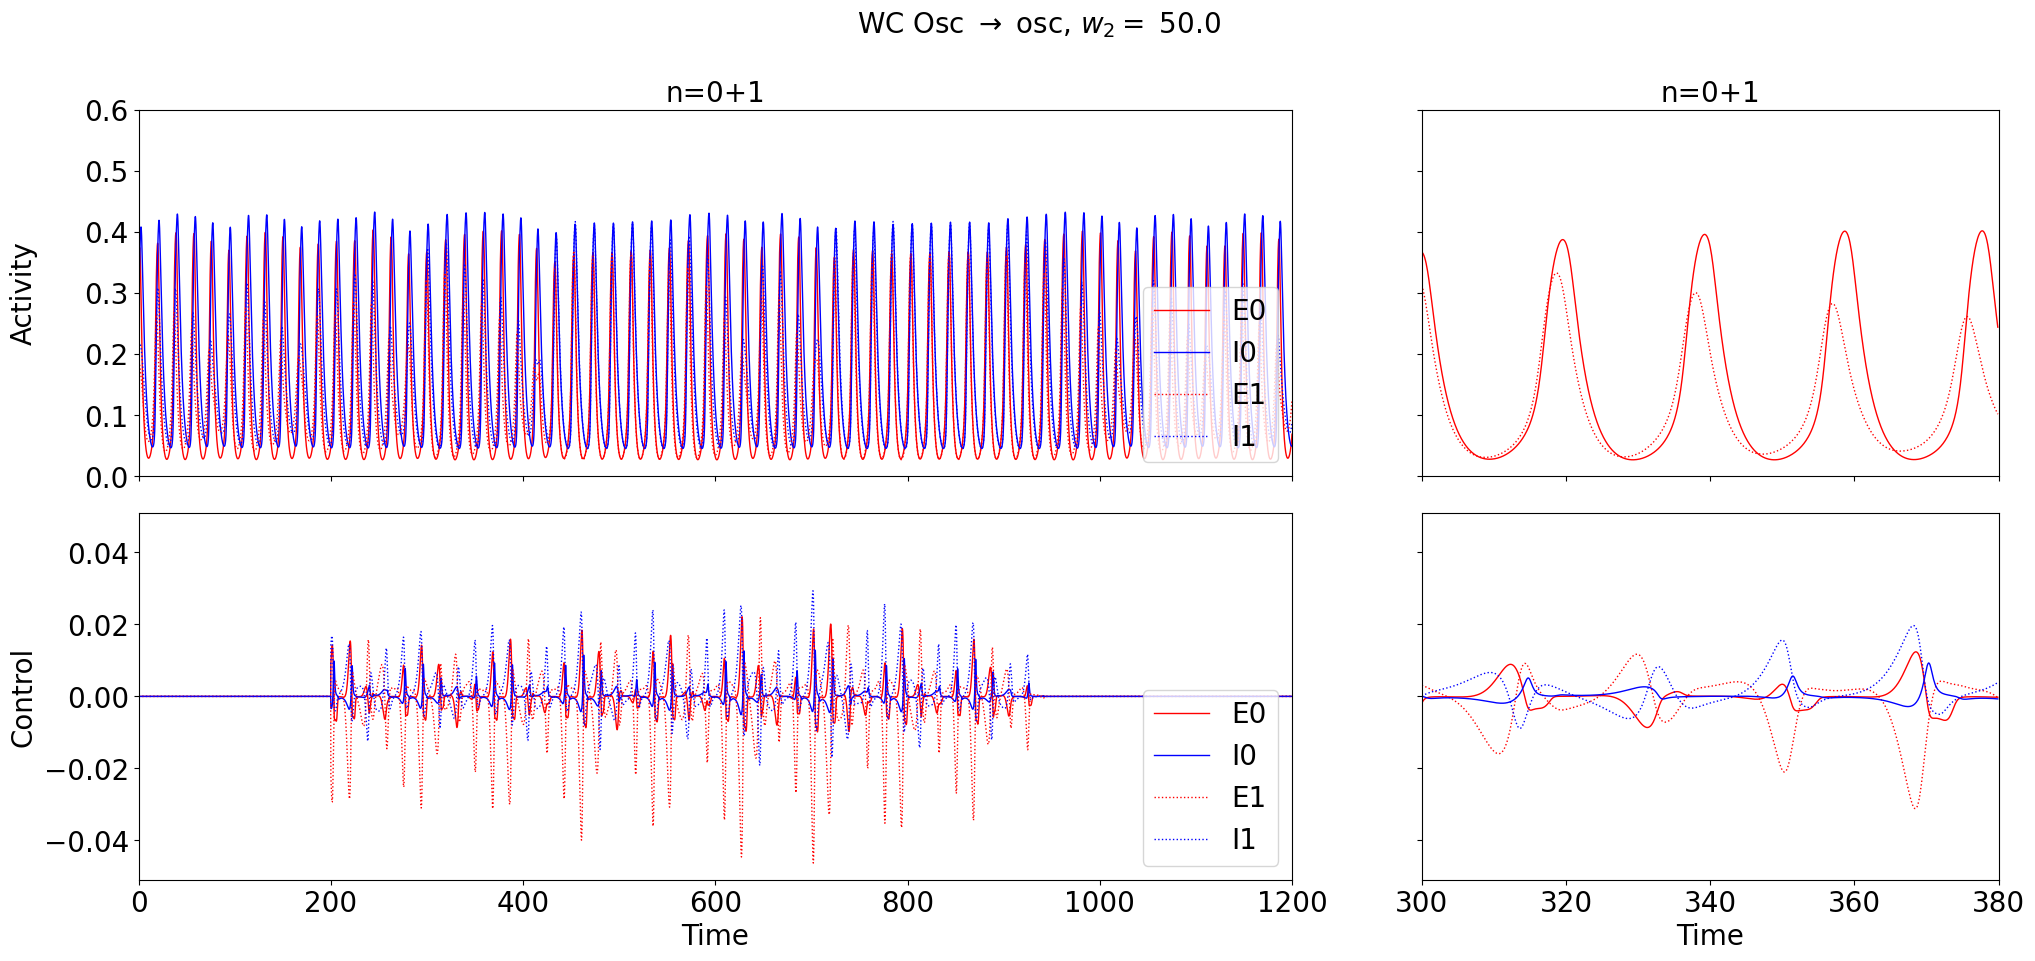

500.0


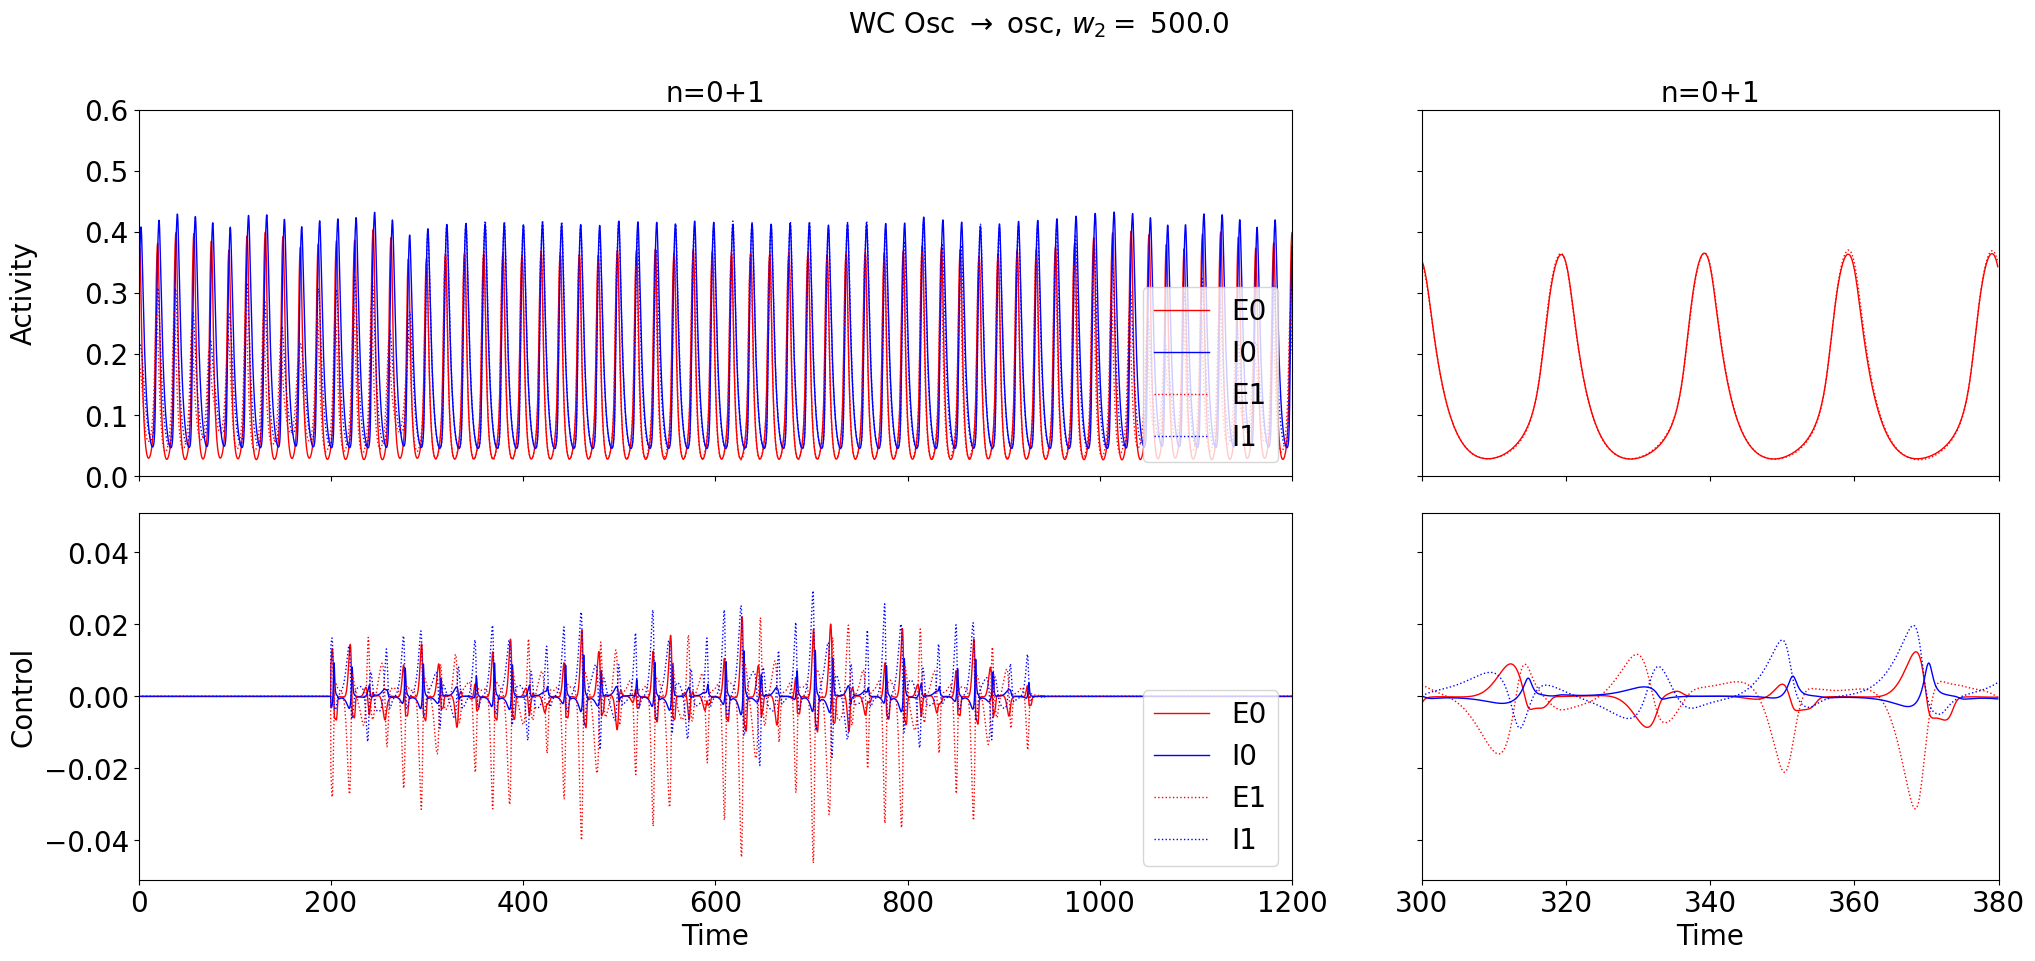

In [ ]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" in p:
        continue

    if pi not in [0]: continue

    print("Point ", p)

    for wi in range(len(data[p]["weight"])):

        print(data[p]["weight"][wi])

        filename = os.path.join(dir, str(p) + "_" + str(wi) + ".png")
        title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][wi])
        plot_control(data[p],  data[p]["dur/per"][0], dt, wi, filename=filename, title=title)

In [104]:
y0lim = [0, 0.6]

def plot_control(c, s, dur, dt, filename=None, title=None, coc=None):
    if dur < 300:
        y1lim = [1.1 * np.amin(c[:,:,1:]), 1.1 * np.amax(c[:,:,1:])]
        fig, ax = plt.subplots(2,1, figsize=(18,8), sharex=True)
    else:
        y1lim = [1.1 * np.amin(c), 1.1 * np.amax(c)]
        fig, ax = plt.subplots(2,1, figsize=(18,8))

    time_array = np.arange(0, dur+dt, dt)

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0].plot(time_array,s[n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0].plot(time_array, s[n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1].plot(time_array, c[n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1].plot(time_array, c[n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])        

    #ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right")

    ax[0].set_xlim(0, dur)
    ax[1].set_xlim(0, dur)
    ax[0].set_ylim(y0lim)
    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    
    fig.align_ylabels([ax[:]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [ ]:
with open(os.path.join(pickledir, '2n_wc_oscillations_cc.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [ ]:
with open(os.path.join(pickledir, '2n_wc_oscillations_cc.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['Osc', 'Bi-phase-osc', 'Beat', 'Bi-period-osc', 'Bi-stat-osc'])
